#Exploratory Data Analysis (EDA)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
import nltk

from tqdm import trange
from nltk import tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
from nltk.util import ngrams
import itertools

In [2]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

## Sentiment Analysis

In [20]:
class EDA:
    def __init__(self, df=None, labelCol="label", dataset="", textCol="translated_text", custom_labels={}):
        self.labelCol = labelCol
        self.df = df
        self.dataset = dataset
        self.textCol = textCol
        self.custom_labels = custom_labels

    def get_label_distribution(self):
        label_count=self.df[self.labelCol].value_counts()
        print(label_count)

        label_freq = self.df[self.labelCol].value_counts(normalize=True)
        print(label_freq)

    def pie_chart_sentiment_distribution(self):
        # Mapping labels to corresponding sentiment names
        label_map = self.custom_labels

        # Get value counts and map labels
        counts = self.df[self.labelCol].value_counts()
        for label in counts.index:
            print(label_map[label])
        labels = [label_map[label] for label in counts.index]  # Convert numbers to words


        # Plot pie chart
        plt.pie(counts, labels=labels, autopct='%1.1f%%')
        plt.show()

    def bar_plot_sentiment_distribution(self):
        """ Check for class balance by plotting the distribution of sentiment labels. """

        label_counts = self.df[self.labelCol].value_counts(normalize=True)

        # Sort index to match barplot order
        sorted_categories = label_counts.index  # Categories in the order they are plotted
        new_x_labels = [self.custom_labels.get(label, label) for label in sorted_categories]

        # Plot
        plt.figure(figsize=(8, 5))
        sns.barplot(x=sorted_categories, y=label_counts.values, palette="viridis", order=sorted_categories)

        # Rename x-axis labels
        plt.xticks(ticks=range(len(new_x_labels)), labels=new_x_labels, rotation=45)

        # Labels and title
        plt.xlabel("Category", fontsize=12)
        plt.ylabel("Proportion", fontsize=12)
        plt.title("Normalized Frequency of Each Category", fontsize=14)

        # Show plot
        plt.show()

    def text_length_distribution(self):
        """
        Analyze Text Length Distribution. Plot the distribution of review lengths (number of words or characters).
        This helps identify outliers (e.g., extremely short or long reviews).
        This can suggest preprocessing strategies (e.g., removing very short reviews).
        """
        # Convert text to string
        self.df[self.textCol] = self.df[self.textCol].astype(str)

        # Compute review lengths
        self.df["text_length"] = self.df[self.textCol].apply(lambda x: len(x.split()))
        print("Text lengths: ", self.df["text_length"].unique())
        print("Average text length: ", self.df["text_length"].mean())

        # Plot distribution
        plt.figure(figsize=(8, 5))
        sns.histplot(self.df["text_length"], bins=30, kde=True)
        plt.xlabel("Review Length (Words)", fontsize=12)
        plt.ylabel("Frequency", fontsize=12)
        plt.title("Distribution of Review Lengths", fontsize=14)
        plt.show()

    def get_most_frequent_words(self):
        nltk.download("stopwords")
        stop_words = set(stopwords.words("english"))  # Adjust for your dataset's language

        # Tokenize and filter stopwords
        self.df["filtered_text"] = self.df[self.textCol].apply(
            lambda x: [word for word in x.lower().split() if word not in stop_words]
        )

        # Count words
        all_words = [word for text in self.df["filtered_text"] for word in text]
        word_freq = Counter(all_words).most_common(20)

        # Convert to DataFrame for plotting
        df_word_freq = pd.DataFrame(word_freq, columns=["Word", "Frequency"])

        # Plot
        plt.figure(figsize=(10, 5))
        sns.barplot(x="Frequency", y="Word", data=df_word_freq, palette="coolwarm")
        plt.xlabel("Frequency", fontsize=12)
        plt.ylabel("Word", fontsize=12)
        plt.title("Most Frequent Words (Excluding Stopwords)", fontsize=14)
        plt.show()

    def get_most_frequent_words_by_sentiment(self, num_words=20):
        stop_words = set(stopwords.words("english"))  # Adjust for the dataset's language

        # Get unique sentiment labels
        sentiment_labels = self.df[self.labelCol].unique()

        # Plot for each sentiment label
        for label in sentiment_labels:
            # Filter dataset by sentiment label
            df_filtered = self.df[self.df[self.labelCol] == label]

            # Tokenize and remove stopwords
            df_filtered["filtered_text"] = df_filtered[self.textCol].apply(
                lambda x: [word for word in x.lower().split() if word not in stop_words]
            )

            # Count words
            all_words = [word for text in df_filtered["filtered_text"] for word in text]
            word_freq = Counter(all_words).most_common(num_words)

            # Convert to DataFrame for plotting
            df_word_freq = pd.DataFrame(word_freq, columns=["Word", "Frequency"])

            label_name = self.custom_labels.get(label, label)

            # Plot
            plt.figure(figsize=(10, 5))
            sns.barplot(x="Frequency", y="Word", data=df_word_freq, palette="coolwarm")
            plt.xlabel("Frequency", fontsize=12)
            plt.ylabel("Word", fontsize=12)
            plt.title(f"Most Frequent Words for Sentiment Label: {label_name}", fontsize=14)
            plt.show()

    def tokenize(self, text):
          return [word.lower() for word in nltk.word_tokenize(text) if word.isalpha()]

    # Function to extract n-grams
    def get_ngrams(self, texts, n=2):
        all_ngrams = list(itertools.chain(*[list(ngrams(self.tokenize(text), n)) for text in texts]))
        return Counter(all_ngrams).most_common(10)  # Get top 10 n-grams

    def plot_ngrams(self, ngrams_data, title):
        """
        Plots the n-grams using a barplot.
        """
        ngram_df = pd.DataFrame(ngrams_data, columns=["N-gram", "Frequency"])
        ngram_df['N-gram'] = [' '.join(ngram) for ngram in ngram_df['N-gram']]

        plt.figure(figsize=(10, 5))
        sns.barplot(x="Frequency", y="N-gram", data=ngram_df, palette="coolwarm")
        plt.title(title, fontsize=14)
        plt.xlabel("Frequency", fontsize=12)
        plt.ylabel("N-gram", fontsize=12)
        plt.show()


    def n_grams_analysis(self, pos_reviews, neg_reviews):
        # Get bigrams and trigrams for positive reviews
        top_bigrams_pos = self.get_ngrams(pos_reviews, n=2)
        top_trigrams_pos = self.get_ngrams(pos_reviews, n=3)

        # Get bigrams and trigrams for negative reviews
        top_bigrams_neg = self.get_ngrams(neg_reviews, n=2)
        top_trigrams_neg = self.get_ngrams(neg_reviews, n=3)

        print("\nTop Positive Bigrams:")
        print(top_bigrams_pos)

        print("\nTop Negative Bigrams:")
        print(top_bigrams_neg)

        print("\nTop Positive Trigrams:")
        print(top_trigrams_pos)

        print("\nTop Negative Trigrams:")
        print(top_trigrams_neg)

        self.plot_ngrams(top_bigrams_pos, "Top Positive Bigrams")
        self.plot_ngrams(top_bigrams_neg, "Top Negative Bigrams")
        self.plot_ngrams(top_trigrams_pos, "Top Positive Trigrams")
        self.plot_ngrams(top_trigrams_neg, "Top Negative Trigrams")

    def get_word_cloud(self):
        """
        Visualize the most frequent words for positive and negative reviews separately.
        This can help decide whether stopwords should be removed.
        """

        # Generate word clouds
        if self.dataset=="cinexio" or self.dataset=="rureviews":
            custom_labels = ["negative", "neutral", "positive"]
        elif self.dataset=="DBRD":
            custom_labels = ["negative", "positive"]
        elif self.dataset=="ita_tweets" or self.dataset=="weibo":
            custom_labels = ["neutral", "positive", "negative", "mixed"]

        for sentiment in self.df[self.labelCol].unique():
            text = " ".join(self.df[self.df[self.labelCol] == sentiment][self.textCol])
            wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)


            # Plot
            plt.figure(figsize=(8, 4))
            plt.imshow(wordcloud, interpolation="bilinear")
            plt.axis("off")
            plt.title(f"Most Common Words in {custom_labels[int(sentiment)]} Reviews", fontsize=14)
            plt.show()

    def perform_eda(self):
        self.get_label_distribution()
        self.pie_chart_sentiment_distribution()
        self.bar_plot_sentiment_distribution()

        print("\n")
        self.text_length_distribution()
        self.df.info()

        print("\n")

        #print("\n")
        #self.get_word_cloud()



In [8]:
class EDA_2:
    def __init__(self, df=None, labelCol="label", dataset="", textCol="translated_text", custom_labels={}):
        self.labelCol = labelCol
        self.df = df
        self.dataset = dataset
        self.textCol = textCol
        self.custom_labels = custom_labels



    def get_most_frequent_words(self):
        nltk.download("stopwords")
        stop_words = set(stopwords.words("english"))  # Adjust for your dataset's language

        # Tokenize and filter stopwords
        self.df["filtered_text"] = self.df[self.textCol].apply(
            lambda x: [word for word in x.lower().split() if word not in stop_words]
        )

        # Count words
        all_words = [word for text in self.df["filtered_text"] for word in text]
        word_freq = Counter(all_words).most_common(20)

        # Convert to DataFrame for plotting
        df_word_freq = pd.DataFrame(word_freq, columns=["Word", "Frequency"])

        # Plot
        plt.figure(figsize=(10, 5))
        sns.barplot(x="Frequency", y="Word", data=df_word_freq, palette="coolwarm")
        plt.xlabel("Frequency", fontsize=12)
        plt.ylabel("Word", fontsize=12)
        plt.title("Most Frequent Words (Excluding Stopwords)", fontsize=14)
        plt.show()

    def get_most_frequent_words_by_sentiment(self, num_words=20):
        stop_words = set(stopwords.words("english"))  # Adjust for the dataset's language

        # Get unique sentiment labels
        sentiment_labels = self.df[self.labelCol].unique()

        # Plot for each sentiment label
        for label in sentiment_labels:
            # Filter dataset by sentiment label
            df_filtered = self.df[self.df[self.labelCol] == label]

            # Tokenize and remove stopwords
            df_filtered["filtered_text"] = df_filtered[self.textCol].apply(
                lambda x: [word for word in x.lower().split() if word not in stop_words]
            )

            # Count words
            all_words = [word for text in df_filtered["filtered_text"] for word in text]
            word_freq = Counter(all_words).most_common(num_words)

            # Convert to DataFrame for plotting
            df_word_freq = pd.DataFrame(word_freq, columns=["Word", "Frequency"])

            label_name = self.custom_labels.get(label, label)

            # Plot
            plt.figure(figsize=(10, 5))
            sns.barplot(x="Frequency", y="Word", data=df_word_freq, palette="coolwarm")
            plt.xlabel("Frequency", fontsize=12)
            plt.ylabel("Word", fontsize=12)
            plt.title(f"Most Frequent Words for Sentiment Label: {label_name}", fontsize=14)
            plt.show()

    def tokenize(self, text):
          return [word.lower() for word in nltk.word_tokenize(text) if word.isalpha()]

    # Function to extract n-grams
    def get_ngrams(self, texts, n=2):
        all_ngrams = list(itertools.chain(*[list(ngrams(self.tokenize(text), n)) for text in texts]))
        return Counter(all_ngrams).most_common(10)  # Get top 10 n-grams

    def plot_ngrams(self, ngrams_data, title):
        """
        Plots the n-grams using a barplot.
        """
        ngram_df = pd.DataFrame(ngrams_data, columns=["N-gram", "Frequency"])
        ngram_df['N-gram'] = [' '.join(ngram) for ngram in ngram_df['N-gram']]

        plt.figure(figsize=(10, 5))
        sns.barplot(x="Frequency", y="N-gram", data=ngram_df, palette="coolwarm")
        plt.title(title, fontsize=14)
        plt.xlabel("Frequency", fontsize=12)
        plt.ylabel("N-gram", fontsize=12)
        plt.show()


    def n_grams_analysis(self, pos_reviews, neg_reviews):
        # Get bigrams and trigrams for positive reviews
        top_bigrams_pos = self.get_ngrams(pos_reviews, n=2)
        top_trigrams_pos = self.get_ngrams(pos_reviews, n=3)

        # Get bigrams and trigrams for negative reviews
        top_bigrams_neg = self.get_ngrams(neg_reviews, n=2)
        top_trigrams_neg = self.get_ngrams(neg_reviews, n=3)

        print("\nTop Positive Bigrams:")
        print(top_bigrams_pos)

        print("\nTop Negative Bigrams:")
        print(top_bigrams_neg)

        print("\nTop Positive Trigrams:")
        print(top_trigrams_pos)

        print("\nTop Negative Trigrams:")
        print(top_trigrams_neg)

        self.plot_ngrams(top_bigrams_pos, "Top Positive Bigrams")
        self.plot_ngrams(top_bigrams_neg, "Top Negative Bigrams")
        self.plot_ngrams(top_trigrams_pos, "Top Positive Trigrams")
        self.plot_ngrams(top_trigrams_neg, "Top Negative Trigrams")

    def perform_eda(self):
        self.get_most_frequent_words()
        print("\n")
        self.get_most_frequent_words_by_sentiment()
        print("\n")

        if self.dataset == "cinexio" or self.dataset=="rureviews":
            positive = self.df[self.df[self.labelCol] == 2][self.textCol]
            negative = self.df[self.df[self.labelCol] == 0][self.textCol]
        elif self.dataset == "DBRD":
            positive = self.df[self.df[self.labelCol] == 1][self.textCol]
            negative = self.df[self.df[self.labelCol] == 0][self.textCol]
        elif self.dataset == "ita_tweets":
            positive = self.df[self.df[self.labelCol] == 0][self.textCol]
            negative = self.df[self.df[self.labelCol] == 1][self.textCol]
        elif self.dataset == "weibo":
            positive = self.df[self.df[self.labelCol] == 1][self.textCol]
            negative = self.df[self.df[self.labelCol] == 0][self.textCol]
        self.n_grams_analysis(positive, negative)


### Bulgarian Cinexio Dataset

In [ ]:
train_bg = pd.read_csv("/content/cinexio_bg_train_final_translated.csv")
val_bg = pd.read_csv("/content/cinexio_bg_val_final_translated.csv")
test_bg = pd.read_csv("/content/cinexio_bg_test_final_translated.csv")

In [ ]:
train_bg.head()

ID                               Cinexio_URL  \
0  6520  http://www.cinexio.com/sofia/movie/17768   
1  6521  http://www.cinexio.com/sofia/movie/17768   
2  6522  http://www.cinexio.com/sofia/movie/17768   
3  6523  http://www.cinexio.com/sofia/movie/17768   
4  6524  http://www.cinexio.com/sofia/movie/17768   

                                             Comment  User_Rating        Date  \
0                                 Много ми хареса...          5.0  2015-03-26   
1                               Супер свежо филмче:)          5.0  2015-03-27   
2                           Супер е!Много ми хареса!          5.0  2015-03-28   
3                               Забавен заслужава си          4.5  2015-03-29   
4  Много забавен филм, който по британски начин с...          5.0  2015-05-04   

   Category                                    translated_text  
0         2                              I really liked it ...  
1         2                               Super fresh movie :)  
2         2                     It's great! I really liked it!  
3         2                                    Fun is worth it  
4         2  A very funny movie that makes fun of old spy m...

In [ ]:
# Drop unnecessary columns
train_bg = train_bg.drop(columns=["ID", "Cinexio_URL", "User_Rating", "Date"])
test_bg = test_bg.drop(columns=["ID", "Cinexio_URL", "User_Rating", "Date"])
val_bg = val_bg.drop(columns=["ID", "Cinexio_URL", "User_Rating", "Date"])
train_bg.head(10)

Comment  Category  \
0                                 Много ми хареса...         2   
1                               Супер свежо филмче:)         2   
2                           Супер е!Много ми хареса!         2   
3                               Забавен заслужава си         2   
4  Много забавен филм, който по британски начин с...         2   
5       един от най добрите филми правени по игра :)         2   
6                                  Много силен филм.         2   
7                 Доста приятен. Умерено филосовски.         2   
8  Много добър филм! Силно препоръчвам!! Имайте н...         2   
9                                       Много силен!         2   

                                     translated_text  
0                              I really liked it ...  
1                               Super fresh movie :)  
2                     It's great! I really liked it!  
3                                    Fun is worth it  
4  A very funny movie that makes fun of old spy m...  
5             One of the best movies made by game :)  
6                               A very strong movie.  
7                 Quite nice.Moderately philosovski.  
8  A very good movie!I strongly recommend !!Keep ...  
9                                       Very strong!

In [ ]:
# Since the sentiment categories are not mixed throughout the dataset, we shuffle it
train_bg = train_bg.sample(frac=1, random_state=42).reset_index(drop=True)
test_bg = test_bg.sample(frac=1, random_state=42).reset_index(drop=True)
val_bg = val_bg.sample(frac=1, random_state=42).reset_index(drop=True)
train_bg.head(30)

Comment  Category  \
0                               Наистина страхотен!!!         2   
1                                            уникален         2   
2                        Много добър! Отлични ефекти!         2   
3   Филма е много хубав,принцесата е представена м...         2   
4                                Много добър филм! ;)         2   
5                       Много ефекти и слаб сценарии!         2   
6   Става, но очаквах повече както от  към сюжет т...         1   
7   Очаквах повече от историята. Имаше малко интри...         1   
8                                             Мноо як         2   
9                                          Страхотен.         2   
10                                     Филмът е хубав         2   
11                                   Очаквах повече:(         1   
12                   Уникален филм , заслужава си !!!         2   
13                  Невероятна приказка за възрастни!         2   
14                                         Хубав е :)         2   
15                 Приятен хумор. Много забавен филм.         2   
16  Много стойностен и добре пресъздава играта на ...         2   
17                                            Ужас е!         0   
18  Много свежо филмче! Изненадана съм. Респект къ...         2   
19          Много стойностен филм.Трябва да се гледа!         2   
20                        приятен филм. заслужава си!         2   
21                                        Истински!!!         2   
22              Очаквах повече. Лош избор на актьори.         1   
23                                  Доста тъп филм!!!         0   
24  филмът е добър, но си личи твърде много, че е ...         1   
25                                       нищо особено         1   
26  ако имаше как да му дам 0 щях да го направяЗа ...         0   
27                                             Силен!         2   
28                 Филмчето е добро!Детето го хареса!         2   
29  ехх много отрицателни коментари и някой ще ви ...         2   

                                      translated_text  
0                                    Really great !!!  
1                                              unique  
2                        Very good!Excellent effects!  
3   The movie is very nice, the princess is very w...  
4                                A very good movie!;)  
5                    Many effects and weak scenarios!  
6   It is, but I was expecting more from both the ...  
7   I was expecting more than history.There was a ...  
8                                         Very strong  
9                                              Great.  
10                                  The movie is nice  
11                            I was expecting more :(  
12                  A unique movie, it's worth it !!!  
13                          An incredible adult tale!  
14                                       It's nice :)  
15              Have a nice humor.A very funny movie.  
16  Very valuable and well recreates the game of s...  
17                                     It's a horror!  
18  A very fresh movie!I'm surprised.Respect to th...  
19            Very valuable movie. You have to watch!  
20                   Have a nice movie.It's worth it!  
21                                           Real !!!  
22            I expected more.A bad choice of actors.  
23                             Quite a dumb movie !!!  
24  The movie is good, but it can be too much that...  
25                                    nothing special  
26  If I had a way to give him 0 I would make it m...  
27                                            Strong!  
28             The movie is good! The child liked it!  
29  Oh many negative comments and someone will fin...

Category
2    6141
1    1378
0     636
Name: count, dtype: int64
Category
2    0.753035
1    0.168976
0    0.077989
Name: proportion, dtype: float64


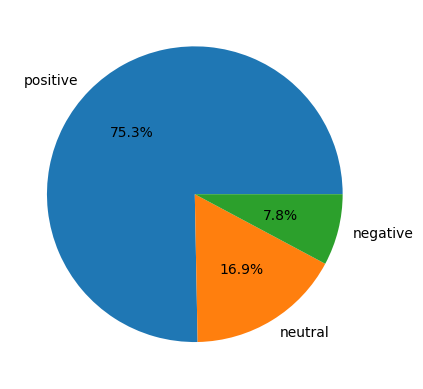

<ipython-input-7-7a5780a7e0a1>:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_categories, y=label_counts.values, palette="viridis", order=sorted_categories)


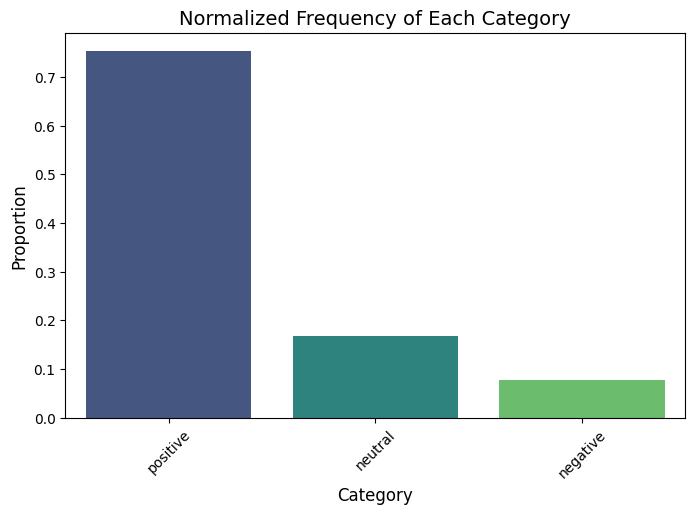



Average text length:  8.166155732679337


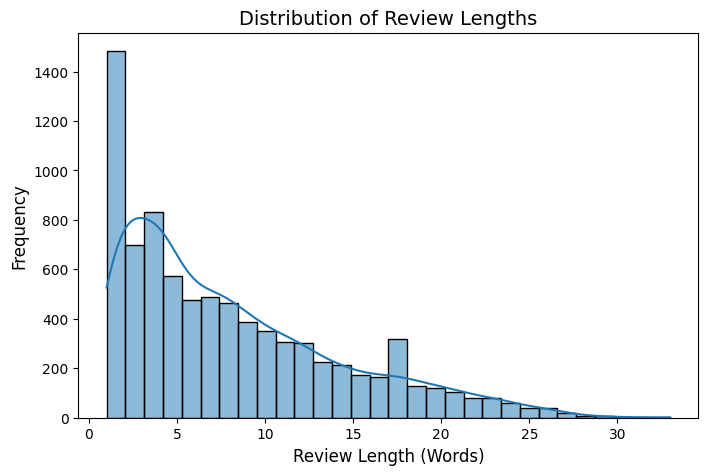

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8155 entries, 0 to 8154
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Comment          8155 non-null   object
 1   Category         8155 non-null   int64 
 2   translated_text  8155 non-null   object
 3   text_length      8155 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 255.0+ KB






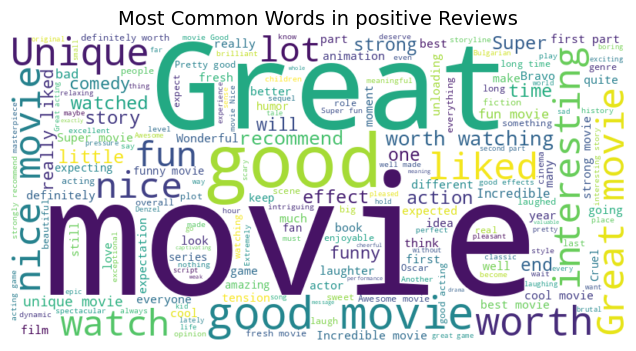

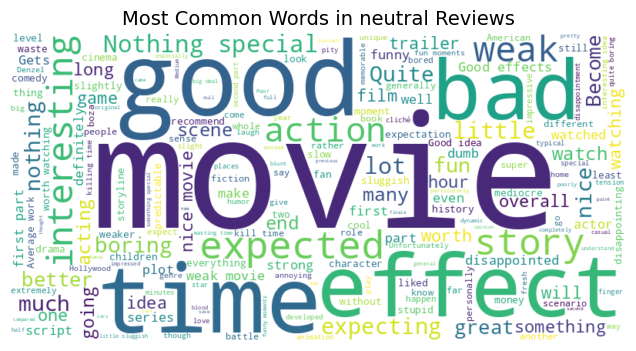

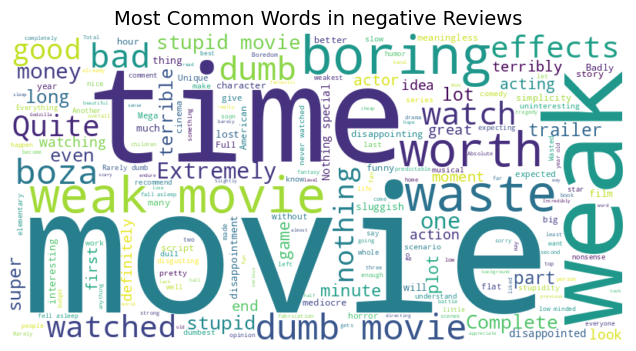

In [ ]:
custom_labels_bg = {
                0: "negative",
                1: "neutral",
                2: "positive",
            }
eda = EDA(df=train_bg, labelCol="Category", dataset="cinexio", textCol="translated_text", custom_labels=custom_labels_bg)
eda.perform_eda()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
<ipython-input-4-9a3c2b2d63d0>:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Frequency", y="Word", data=df_word_freq, palette="coolwarm")


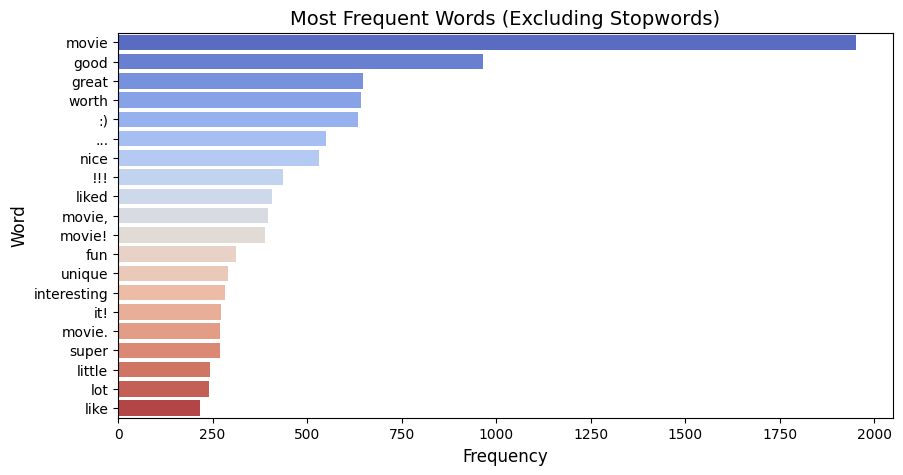

<ipython-input-4-9a3c2b2d63d0>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["filtered_text"] = df_filtered[self.textCol].apply(
<ipython-input-4-9a3c2b2d63d0>:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Frequency", y="Word", data=df_word_freq, palette="coolwarm")


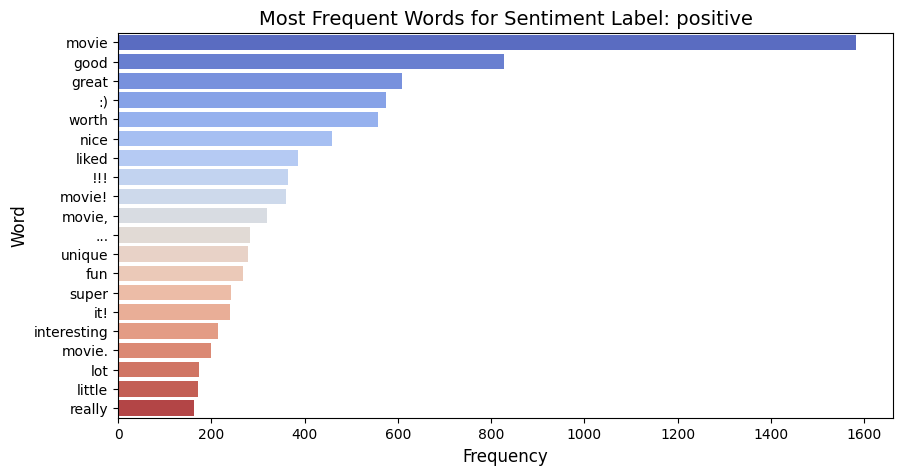

<ipython-input-4-9a3c2b2d63d0>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["filtered_text"] = df_filtered[self.textCol].apply(
<ipython-input-4-9a3c2b2d63d0>:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Frequency", y="Word", data=df_word_freq, palette="coolwarm")


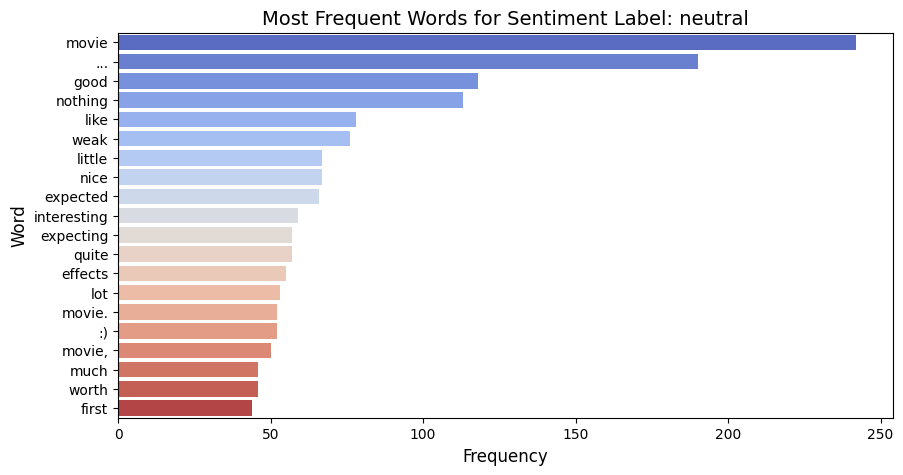

<ipython-input-4-9a3c2b2d63d0>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["filtered_text"] = df_filtered[self.textCol].apply(
<ipython-input-4-9a3c2b2d63d0>:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Frequency", y="Word", data=df_word_freq, palette="coolwarm")


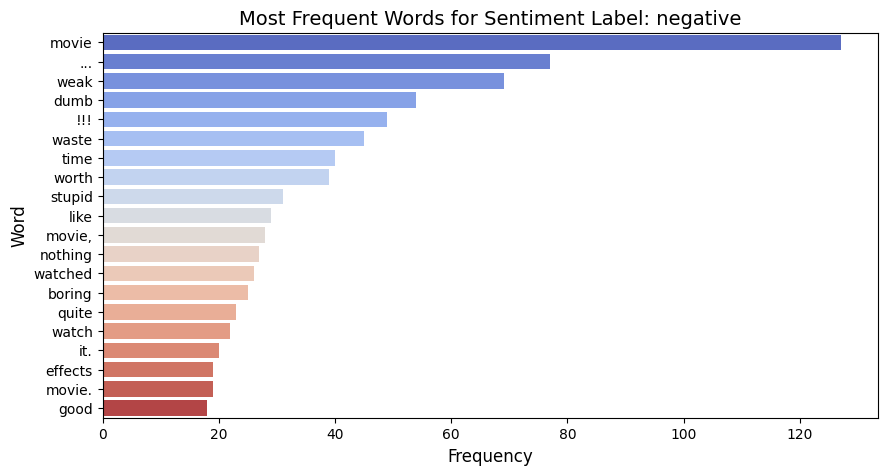




Top Positive Bigrams:
[(('the', 'movie'), 668), (('a', 'very'), 493), (('very', 'good'), 476), (('movie', 'is'), 473), (('good', 'movie'), 344), (('worth', 'it'), 287), (('it', 'worth'), 260), (('great', 'movie'), 254), (('nice', 'movie'), 246), (('of', 'the'), 228)]

Top Negative Bigrams:
[(('the', 'movie'), 48), (('very', 'weak'), 42), (('movie', 'is'), 35), (('a', 'very'), 35), (('not', 'worth'), 34), (('it', 'not'), 30), (('weak', 'movie'), 30), (('worth', 'it'), 30), (('in', 'the'), 27), (('dumb', 'movie'), 24)]

Top Positive Trigrams:
[(('the', 'movie', 'is'), 429), (('a', 'very', 'good'), 203), (('very', 'good', 'movie'), 196), (('it', 'worth', 'it'), 151), (('a', 'lot', 'of'), 131), (('i', 'really', 'liked'), 103), (('very', 'nice', 'movie'), 99), (('movie', 'is', 'great'), 88), (('a', 'very', 'nice'), 87), (('i', 'liked', 'it'), 87)]

Top Negative Trigrams:
[(('the', 'movie', 'is'), 30), (('not', 'worth', 'it'), 26), (('waste', 'of', 'time'), 23), (('it', 'not', 'worth'), 2

<ipython-input-4-9a3c2b2d63d0>:84: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Frequency", y="N-gram", data=ngram_df, palette="coolwarm")


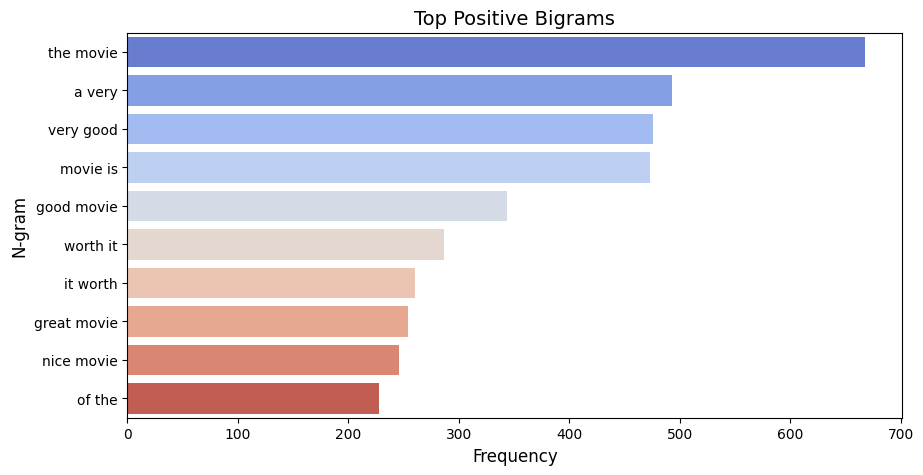

<ipython-input-4-9a3c2b2d63d0>:84: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Frequency", y="N-gram", data=ngram_df, palette="coolwarm")


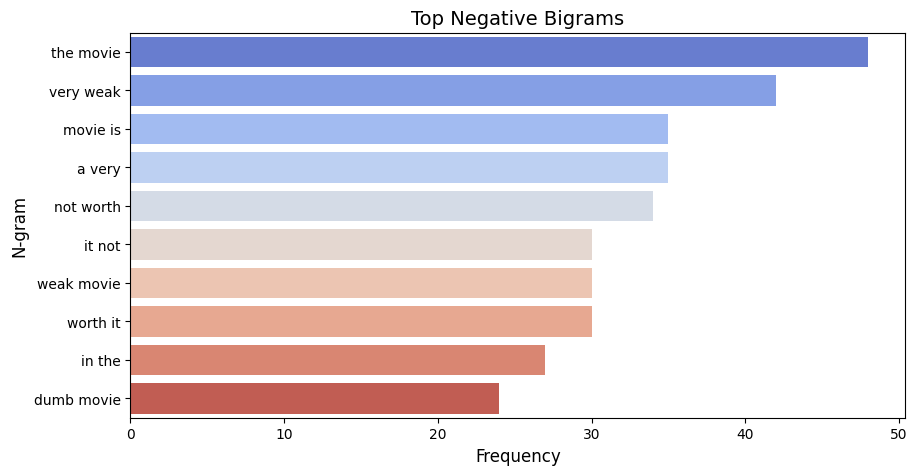

<ipython-input-4-9a3c2b2d63d0>:84: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Frequency", y="N-gram", data=ngram_df, palette="coolwarm")


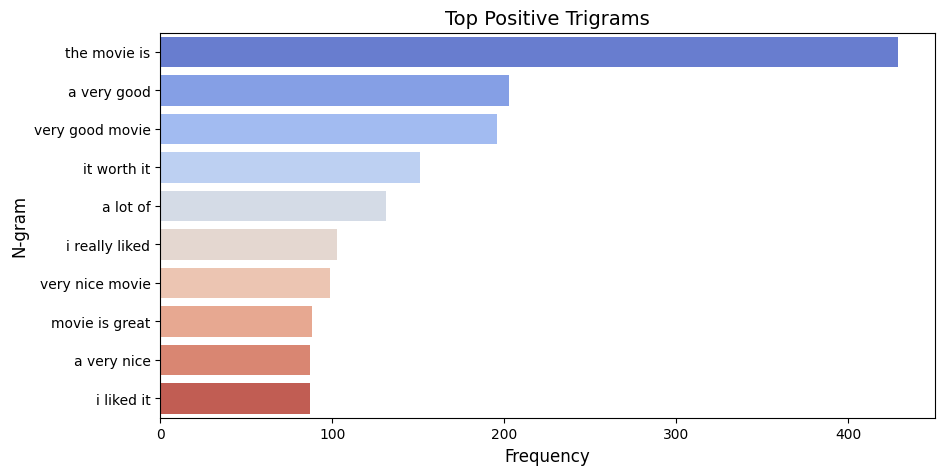

<ipython-input-4-9a3c2b2d63d0>:84: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Frequency", y="N-gram", data=ngram_df, palette="coolwarm")


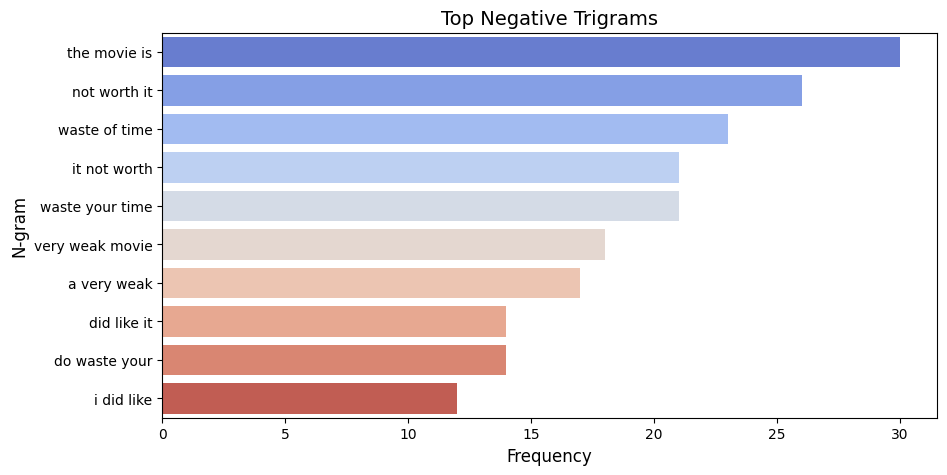

In [ ]:
custom_labels_bg = {
                0: "negative",
                1: "neutral",
                2: "positive",
            }
eda = EDA_2(df=train_bg, labelCol="Category", dataset="cinexio", textCol="translated_text", custom_labels=custom_labels_bg)
eda.perform_eda()

### Dutch Book Reviews Datset

In [ ]:
train_nl = pd.read_csv("/content/DBRD_nl_train_translated.csv")
test_nl = pd.read_csv("/content/DBRD_nl_test_translated.csv")
val_nl = pd.read_csv("/content/DBRD_nl_val_translated.csv")

In [ ]:
train_nl.head()

text  label  \
0  De Vlaamse thriller is in opmars. Onder andere...      1   
1  Geweldig boek weer van Simone van der vlught, ...      1   
2  Dode mannen moorden niet, een boek van Roos Bo...      1   
3  Wat zwaar boek, langdradigitale en traag verha...      0   
4  Om Maria Norberg heen ligt alles en iedereen d...      1   

                                     translated_text  
0  The Flemish thriller is on the rise. Among oth...  
1  Great book again by Simone van der vluchtht, e...  
2  Dead Men Don't Kill, a book by Roos Boum that ...  
3  What a heavy book, long-winded and slow story....  
4  Around Maria Norberg, everything and everyone ...

label
0    8472
1    8396
Name: count, dtype: int64
label
0    0.502253
1    0.497747
Name: proportion, dtype: float64


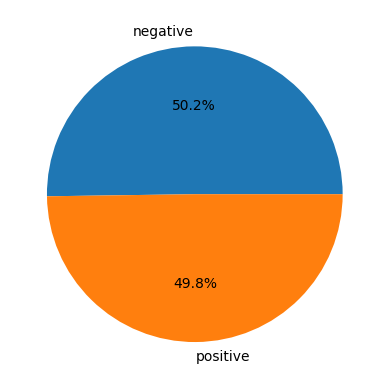

<ipython-input-7-7a5780a7e0a1>:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_categories, y=label_counts.values, palette="viridis", order=sorted_categories)


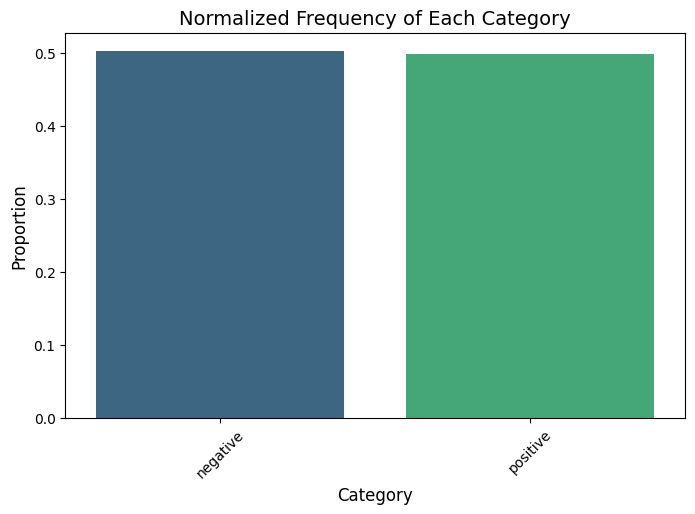



Average text length:  235.6110386530709


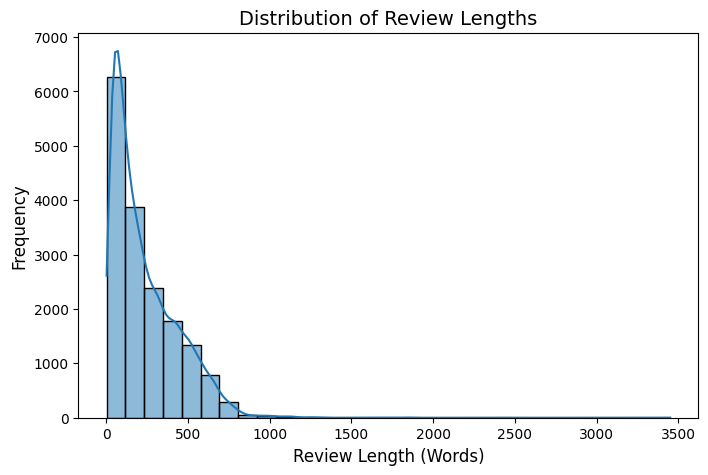

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16868 entries, 0 to 16867
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   text             16868 non-null  object
 1   label            16868 non-null  int64 
 2   translated_text  16868 non-null  object
 3   text_length      16868 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 527.3+ KB






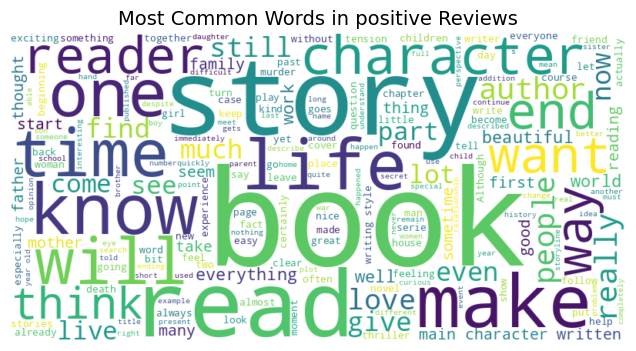

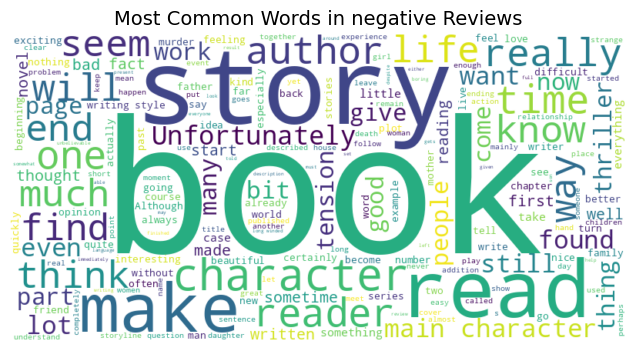

In [ ]:
custom_labels_nl = {
                0: "negative",
                1: "positive"
            }
eda = EDA(df=train_nl, labelCol="label", dataset="DBRD", textCol="translated_text", custom_labels=custom_labels_nl)
eda.perform_eda()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
<ipython-input-4-9a3c2b2d63d0>:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Frequency", y="Word", data=df_word_freq, palette="coolwarm")


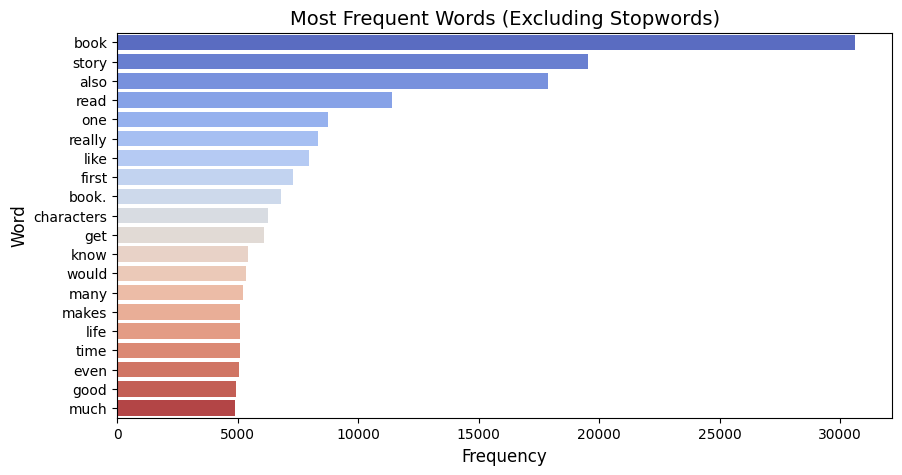

<ipython-input-4-9a3c2b2d63d0>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["filtered_text"] = df_filtered[self.textCol].apply(
<ipython-input-4-9a3c2b2d63d0>:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Frequency", y="Word", data=df_word_freq, palette="coolwarm")


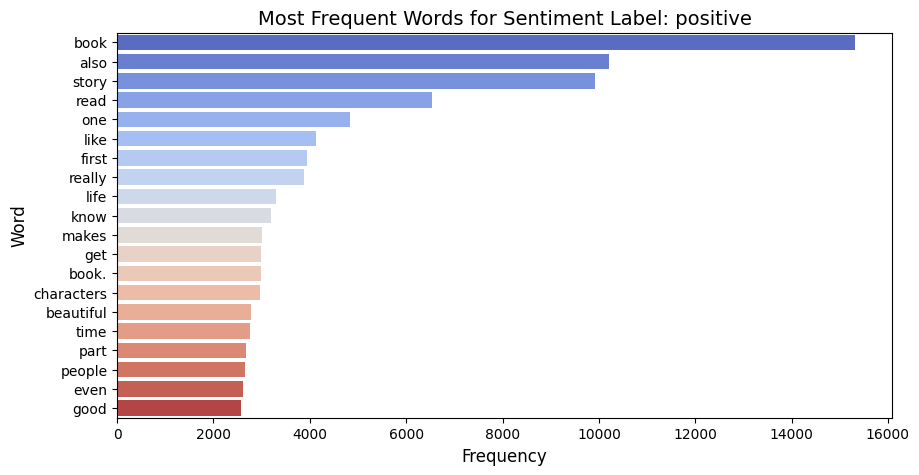

<ipython-input-4-9a3c2b2d63d0>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["filtered_text"] = df_filtered[self.textCol].apply(
<ipython-input-4-9a3c2b2d63d0>:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Frequency", y="Word", data=df_word_freq, palette="coolwarm")


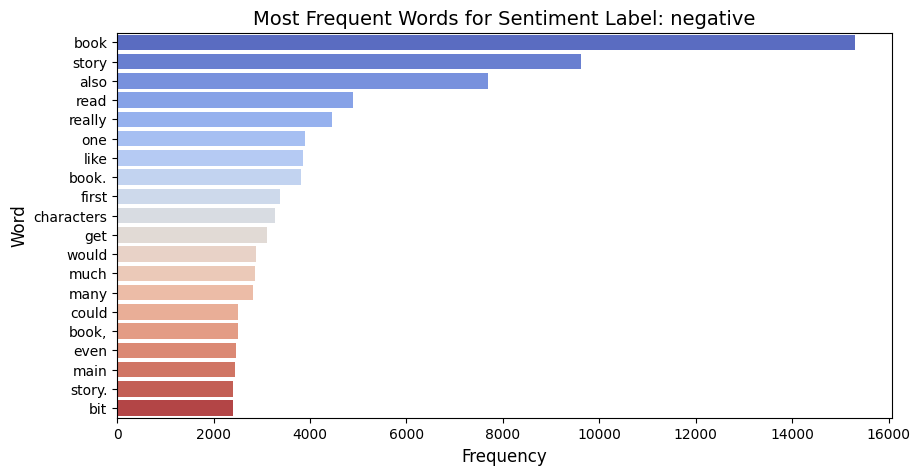




Top Positive Bigrams:
[(('of', 'the'), 12730), (('in', 'the'), 12507), (('the', 'book'), 8421), (('the', 'story'), 7913), (('it', 'is'), 7343), (('is', 'a'), 6398), (('and', 'the'), 5351), (('to', 'the'), 5245), (('this', 'book'), 4997), (('in', 'a'), 4123)]

Top Negative Bigrams:
[(('of', 'the'), 12284), (('in', 'the'), 10888), (('the', 'book'), 9863), (('the', 'story'), 8677), (('it', 'is'), 6954), (('this', 'book'), 5173), (('is', 'a'), 5100), (('and', 'the'), 4906), (('to', 'the'), 4536), (('is', 'not'), 3752)]

Top Positive Trigrams:
[(('the', 'book', 'is'), 1541), (('the', 'story', 'is'), 1474), (('it', 'is', 'a'), 1465), (('of', 'the', 'book'), 1328), (('a', 'lot', 'of'), 1144), (('in', 'the', 'book'), 1024), (('as', 'a', 'reader'), 926), (('in', 'the', 'story'), 909), (('the', 'main', 'character'), 865), (('this', 'book', 'is'), 842)]

Top Negative Trigrams:
[(('of', 'the', 'book'), 1823), (('the', 'book', 'is'), 1658), (('the', 'story', 'is'), 1486), (('a', 'lot', 'of'), 13

<ipython-input-4-9a3c2b2d63d0>:84: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Frequency", y="N-gram", data=ngram_df, palette="coolwarm")


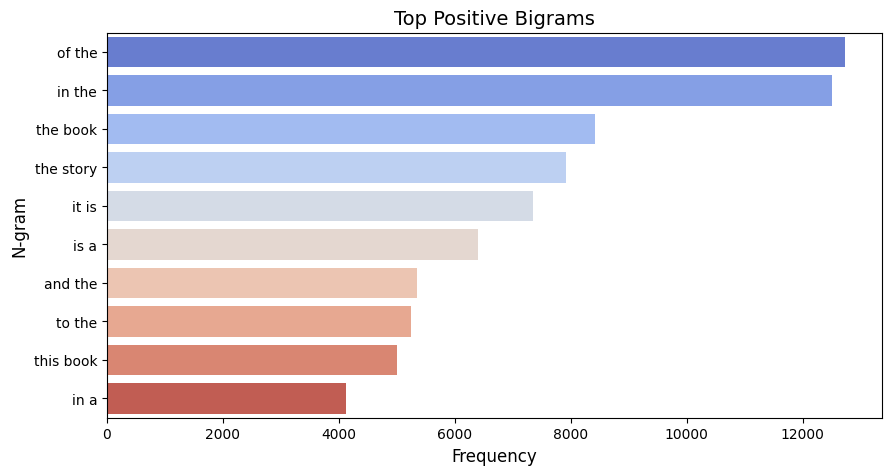

<ipython-input-4-9a3c2b2d63d0>:84: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Frequency", y="N-gram", data=ngram_df, palette="coolwarm")


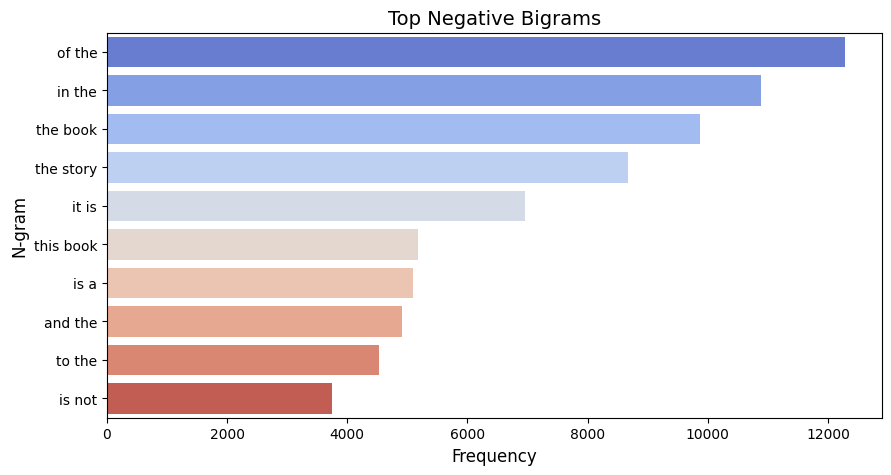

<ipython-input-4-9a3c2b2d63d0>:84: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Frequency", y="N-gram", data=ngram_df, palette="coolwarm")


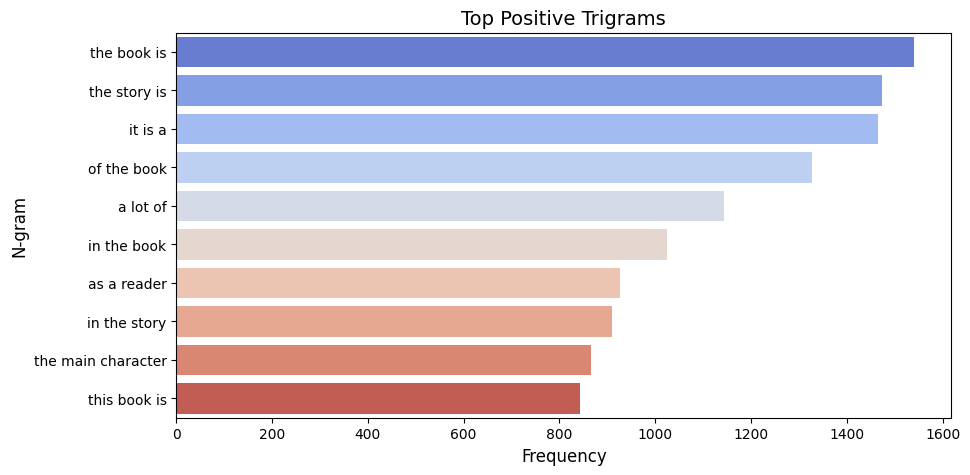

<ipython-input-4-9a3c2b2d63d0>:84: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Frequency", y="N-gram", data=ngram_df, palette="coolwarm")


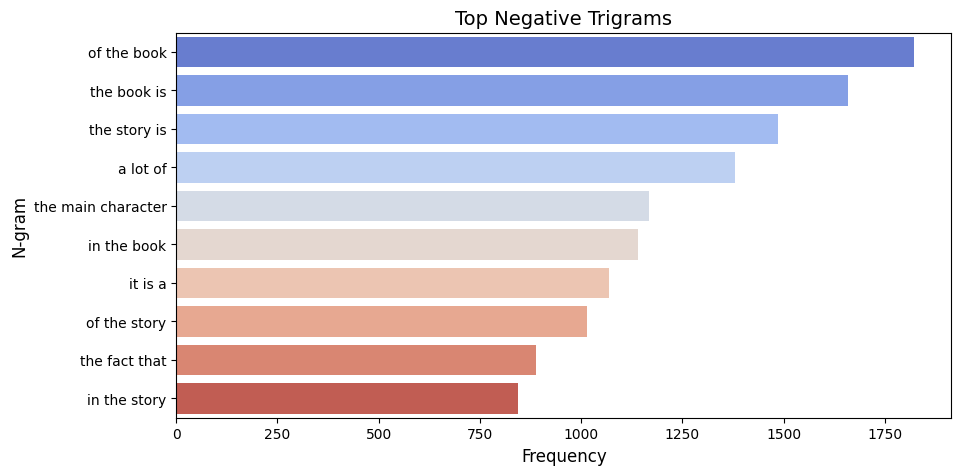

In [ ]:
custom_labels_nl = {
                0: "negative",
                1: "positive"
            }
eda = EDA_2(df=train_nl, labelCol="label", dataset="DBRD", textCol="translated_text", custom_labels=custom_labels_nl)
eda.perform_eda()

### Italian Tweets Dataset

In [ ]:
train_it = pd.read_csv("/content/ita_tweets_train_final.csv")
test_it = pd.read_csv("/content/ita_tweets_it_test_translated.csv")
val_it = pd.read_csv("/content/ita_tweets_it_val_translated.csv")

In [ ]:
train_it.head()

sentiment                                    translated_text
0   NEUTRAL  @RealPiccinini @MarioMandzukic9 Sandro I appre...
1   NEUTRAL  @RollingStoneita @Cristiano @juventusfc What t...
2   NEUTRAL  @realvarrale @jimmyjimmy88 @KMbappe @G_Higuain...
3   NEUTRAL  @lyann1982 @dimpayet17 @omdansle @CoachGracias...
4   NEUTRAL  @xmx_sava @realvarrale @sscnapoli @kkoubibaly2...

In [ ]:
sentiment_mapping = {"POSITIVE": 0, "NEGATIVE": 1, "NEUTRAL": 2, "MIXED": 3}

# Apply mapping to sentiment column
train_it["label"] = train_it["sentiment"].map(sentiment_mapping)
test_it["label"] = test_it["sentiment"].map(sentiment_mapping)
val_it["label"] = val_it["sentiment"].map(sentiment_mapping)

In [ ]:
train_it.head(20)

sentiment                                    translated_text  label
0    NEUTRAL  @RealPiccinini @MarioMandzukic9 Sandro I appre...      2
1    NEUTRAL  @RollingStoneita @Cristiano @juventusfc What t...      2
2    NEUTRAL  @realvarrale @jimmyjimmy88 @KMbappe @G_Higuain...      2
3    NEUTRAL  @lyann1982 @dimpayet17 @omdansle @CoachGracias...      2
4    NEUTRAL  @xmx_sava @realvarrale @sscnapoli @kkoubibaly2...      2
5    NEUTRAL  @Cristiano if you don't find a home give me a ...      2
6   NEGATIVE  @realvarriale @dries_mertens14 @PauDybala_JR @...      1
7    NEUTRAL  @riotta @BeppeSala @Inter @kkoubibaly26 Why in...      2
8   NEGATIVE  The problem is not the despicable insults at @...      1
9    NEUTRAL  @OfficialRadja you will always be one of us.. ...      2
10   NEUTRAL  @EdoSmithJ @giacomobona @VolkerMusahl @UPMCSpo...      2
11  POSITIVE  @OfficialRadja Few words: thank you for wearin...      0
12   NEUTRAL  @RollingStoneita @Cristiano @juventusfc The be...      2
13   NEUTRAL  @MuseeLouvre @equipedefrance @FrenchTeam @FIFA...      2
14   NEUTRAL  @dries_mertens14 @JanVertonghen Congratulation...      2
15     MIXED  @inter2010treble @BbbNunziol @AngeloLosi For m...      3
16   NEUTRAL  @glmdj @kkoubibaly26 @MATUIDIBlaise @ADeLauren...      2
17   NEUTRAL  @eugenio_guitar @joaome17 vabbe but the transa...      2
18   NEUTRAL  @pisto_gol Why, instead of one of the many pho...      2
19   NEUTRAL  @sportlaw93 @LucaMarelli72 @kkounibaly26 It's ...      2

label
2    108164
0     18833
1      5222
3       433
Name: count, dtype: int64
label
2    0.815397
0    0.141973
1    0.039366
3    0.003264
Name: proportion, dtype: float64


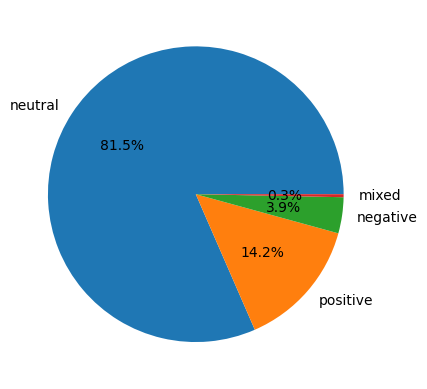

<ipython-input-16-7534db924bd4>:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_categories, y=label_counts.values, palette="viridis", order=sorted_categories)


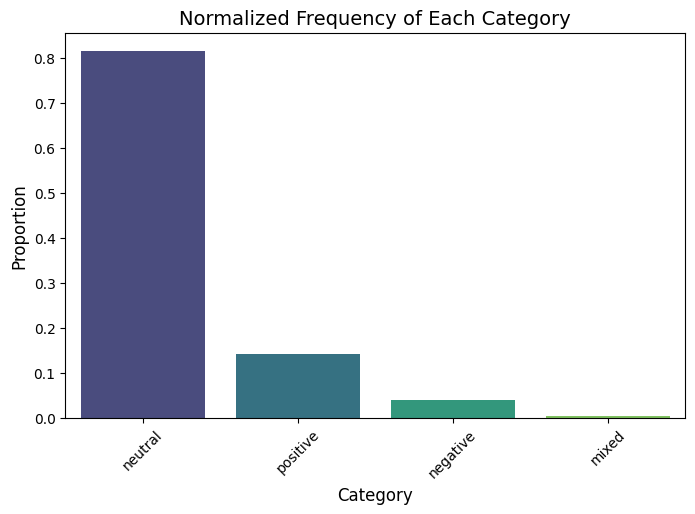



Text lengths:  [ 39  20  44  24  14  19  43  26  36  21   6  22   8  50  12  38  10   9
  33  15  31  11  35  25  13  23  34  40  27  55  48  47  29  18  17   4
  61  51  65  16  37   7  30  32  60  28  52   5  46   3  49  41  56  42
   2  54  58  57  45  68  59  53  71 137  66  87   1  62 170  67  69  63
  64  73 254  88 430 187 185  83 338 343  78 191 150 249  72 325 251 216
  81  80 485 315 280 252 474 272 136 510 110  82  70  75  84  92 428 168
 255 243 256]
Average text length:  19.009498537526763


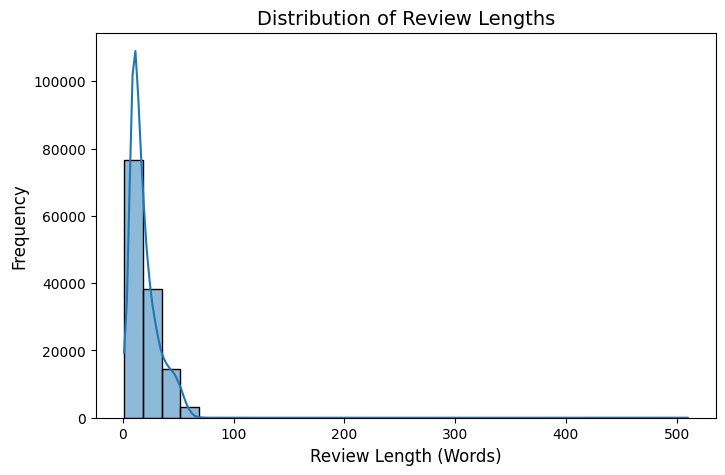

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132652 entries, 0 to 132651
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   sentiment        132652 non-null  object
 1   translated_text  132652 non-null  object
 2   label            132652 non-null  int64 
 3   text_length      132652 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 4.0+ MB






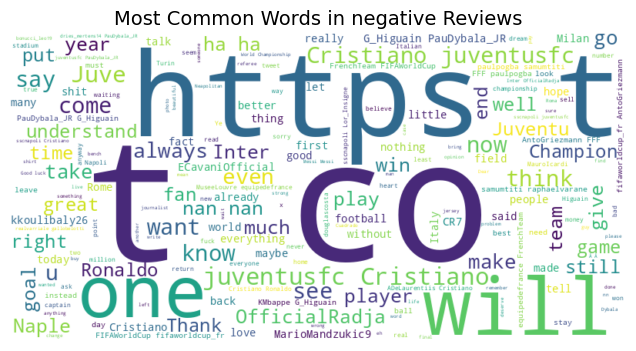

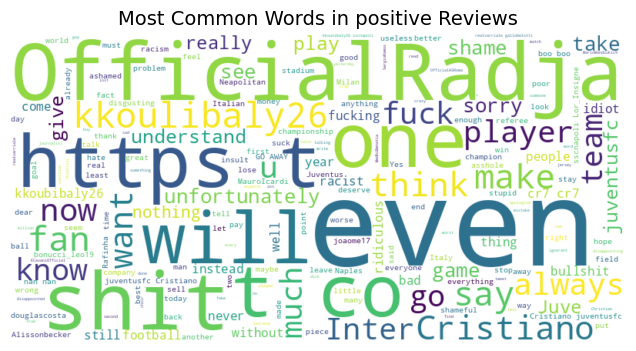

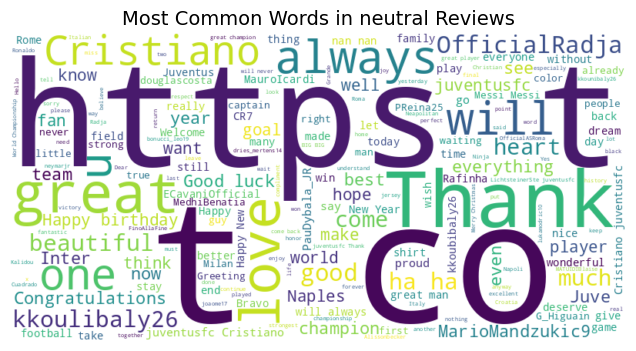

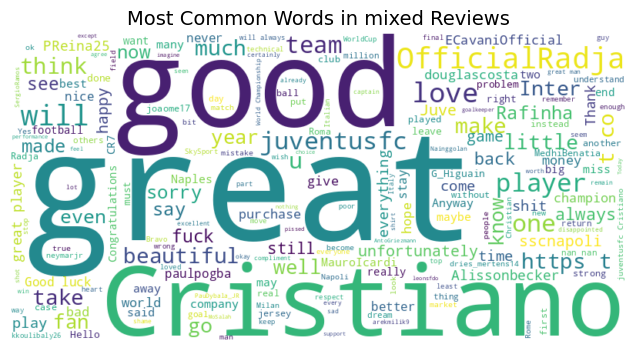

In [ ]:
custom_labels_it = {
                2: "neutral",
                0: "positive",
                1: "negative",
                3: "mixed"
            }
eda = EDA(df=train_it, labelCol="label", dataset="ita_tweets", textCol="translated_text", custom_labels=custom_labels_it)
eda.perform_eda()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
<ipython-input-19-c5e1edaad954>:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Frequency", y="Word", data=df_word_freq, palette="coolwarm")


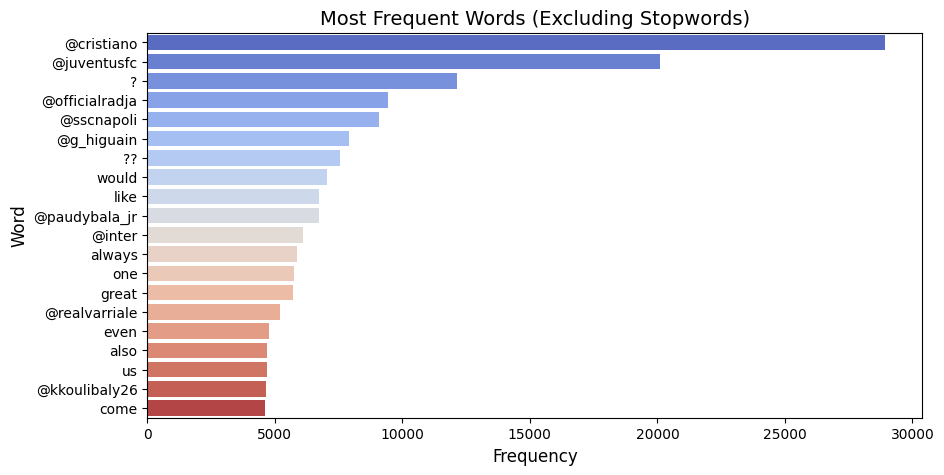

<ipython-input-19-c5e1edaad954>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["filtered_text"] = df_filtered[self.textCol].apply(
<ipython-input-19-c5e1edaad954>:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Frequency", y="Word", data=df_word_freq, palette="coolwarm")


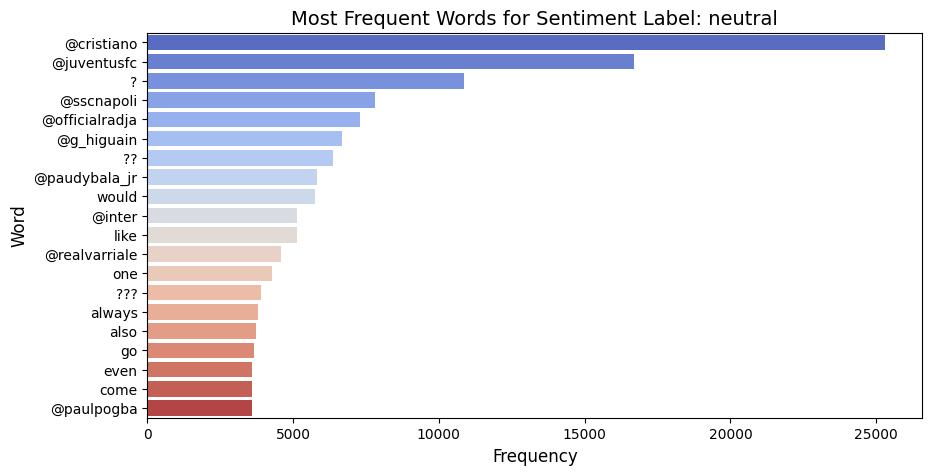

<ipython-input-19-c5e1edaad954>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["filtered_text"] = df_filtered[self.textCol].apply(
<ipython-input-19-c5e1edaad954>:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Frequency", y="Word", data=df_word_freq, palette="coolwarm")


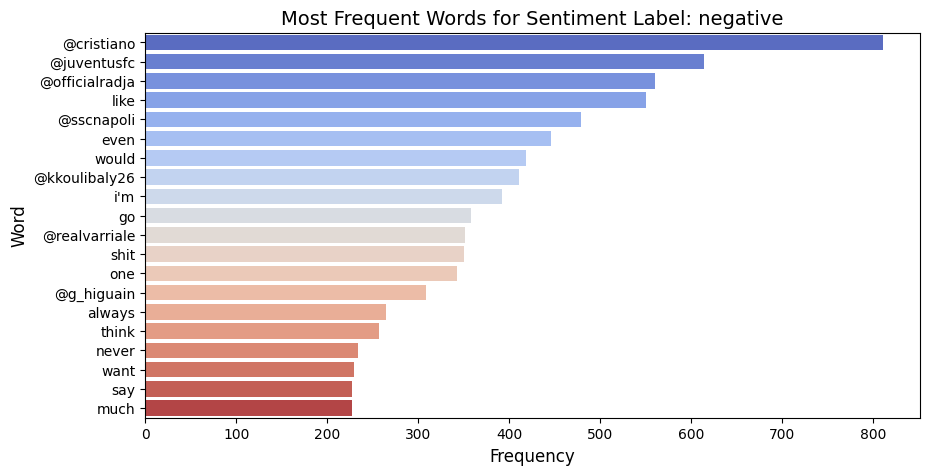

<ipython-input-19-c5e1edaad954>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["filtered_text"] = df_filtered[self.textCol].apply(
<ipython-input-19-c5e1edaad954>:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Frequency", y="Word", data=df_word_freq, palette="coolwarm")


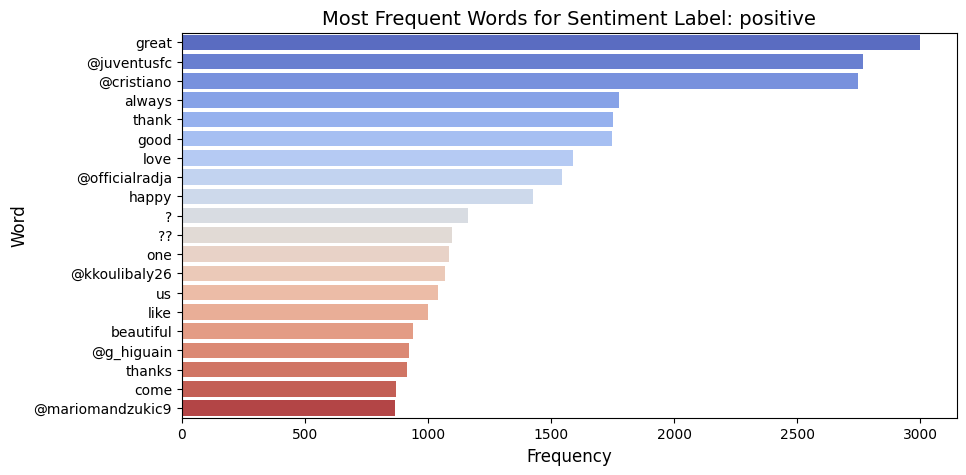

<ipython-input-19-c5e1edaad954>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["filtered_text"] = df_filtered[self.textCol].apply(
<ipython-input-19-c5e1edaad954>:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Frequency", y="Word", data=df_word_freq, palette="coolwarm")


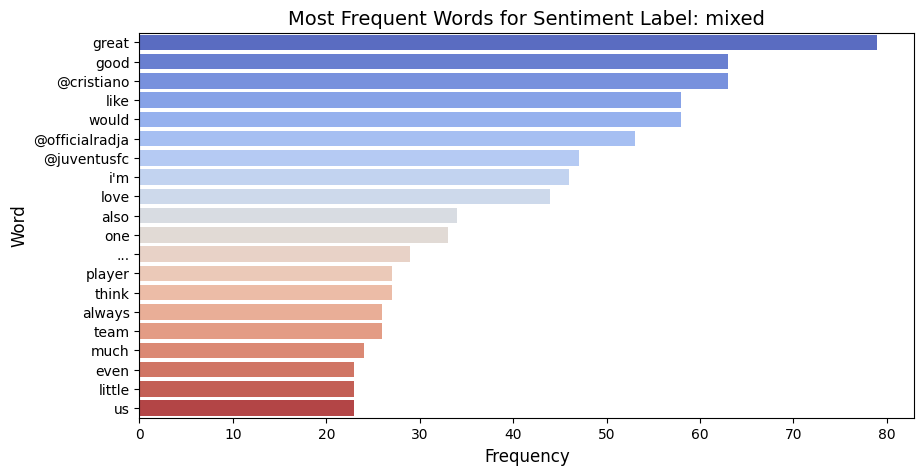




Top Positive Bigrams:
[(('you', 'are'), 1911), (('thank', 'you'), 1702), (('in', 'the'), 1412), (('of', 'the'), 1342), (('a', 'great'), 1245), (('love', 'you'), 972), (('for', 'the'), 881), (('ha', 'ha'), 841), (('to', 'the'), 783), (('the', 'best'), 725)]

Top Negative Bigrams:
[(('of', 'the'), 514), (('you', 'are'), 492), (('in', 'the'), 443), (('i', 'do'), 304), (('on', 'the'), 256), (('to', 'the'), 248), (('it', 'is'), 247), (('you', 'have'), 237), (('you', 'do'), 222), (('have', 'to'), 220)]

Top Positive Trigrams:
[(('ha', 'ha', 'ha'), 835), (('you', 'are', 'a'), 565), (('i', 'love', 'you'), 538), (('thank', 'you', 'for'), 494), (('in', 'the', 'world'), 348), (('are', 'a', 'great'), 346), (('happy', 'new', 'year'), 337), (('one', 'of', 'the'), 260), (('we', 'love', 'you'), 254), (('messi', 'messi', 'messi'), 253)]

Top Negative Trigrams:
[(('you', 'have', 'to'), 102), (('you', 'are', 'a'), 97), (('what', 'the', 'fuck'), 60), (('piece', 'of', 'shit'), 54), (('you', 'are', 'the'

<ipython-input-19-c5e1edaad954>:84: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Frequency", y="N-gram", data=ngram_df, palette="coolwarm")


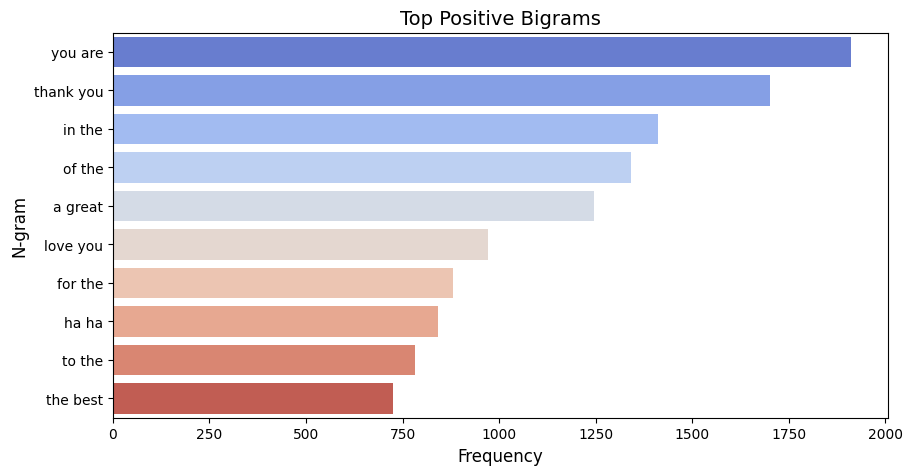

<ipython-input-19-c5e1edaad954>:84: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Frequency", y="N-gram", data=ngram_df, palette="coolwarm")


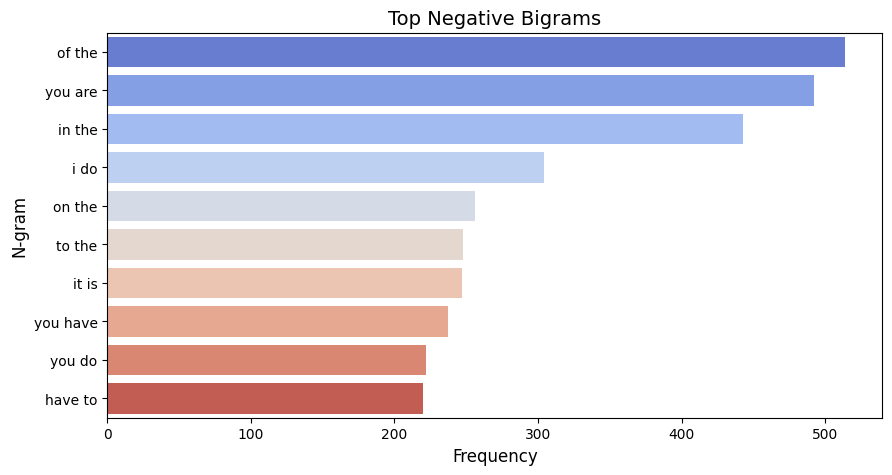

<ipython-input-19-c5e1edaad954>:84: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Frequency", y="N-gram", data=ngram_df, palette="coolwarm")


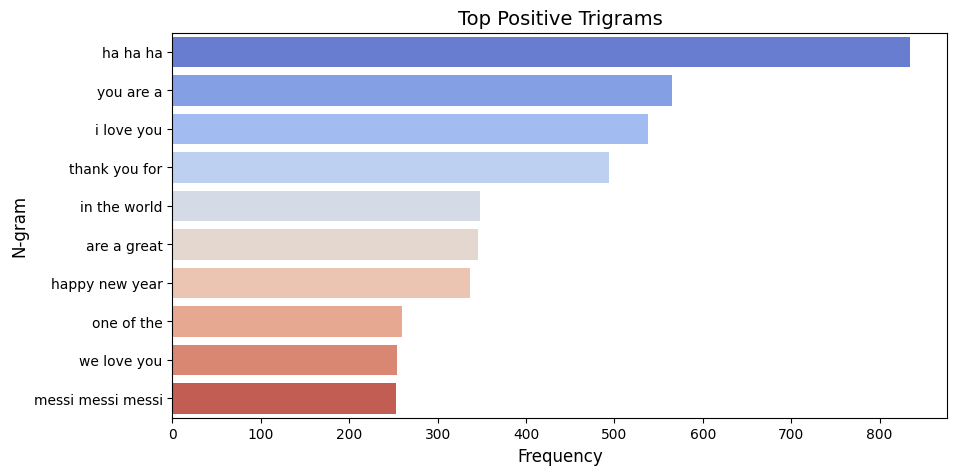

<ipython-input-19-c5e1edaad954>:84: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Frequency", y="N-gram", data=ngram_df, palette="coolwarm")


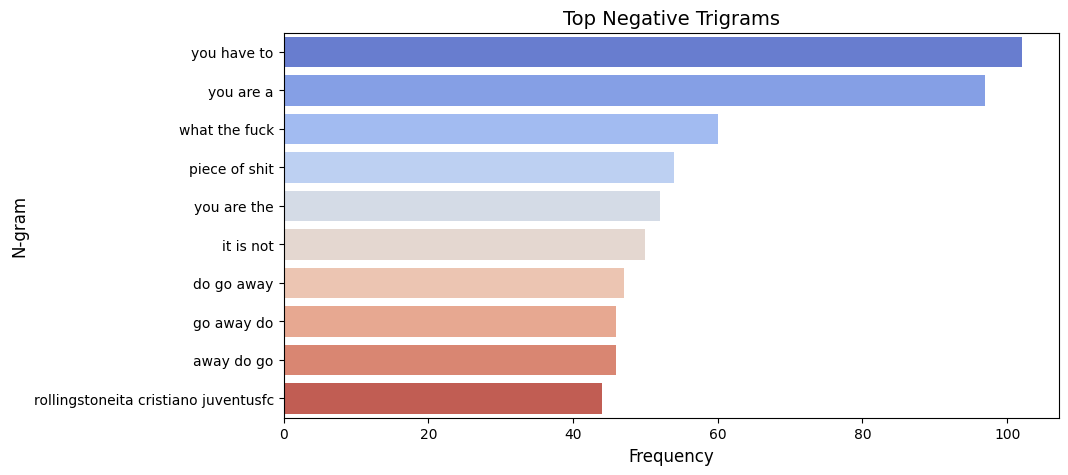

In [ ]:
eda = EDA_2(df=train_it, labelCol="label", dataset="ita_tweets", textCol="translated_text", custom_labels=custom_labels_it)
eda.perform_eda()

### Chinese Weibo

In [ ]:
train_ch = pd.read_csv("/content/weibo_ch_train_translated.csv")
val_ch = pd.read_csv("/content/weibo_ch_val.csv_translated.csv")
test_ch = pd.read_csv("/content/weibo_ch_test_translated.csv")
train_ch.head()

label                                             review  \
0      1  [赞]//@京M银狐: 等待时机[哈哈]//@准备微笑的海燕: 太美了太美了！[花心][花心...   
1      1  最经典应该是“荷兰银行支票”，[哈哈][哈哈] //@梁sisi:HOLAND MOON[偷...   
2      1  基础不牢，通航发展滞后。 //@KCD777://@张起淮:堵的貌似强硬，实是虚弱[哈哈] ...   
3      0  回复@黎筱婷子:我们在东北种大豆，使用中国本产非转基因大豆品种，?成豆浆粉送瑞士SGS非转基...   
4      1  [哈哈] //@泉州女一号:[围观]完全能理解！如果彩排时?现过类似的情况估计直播时就会加以...   

                                     translated_text  
0  [Zanky]/@KingM Silver Fox: Waiting for the tim...  
1  The classic should be a Dutch bank cheque, [Ha...  
2  The base is weak, and navigation lags behind. ...  
3  @LiXinziko: We grow soy beans in the northeast...  
4  [Haha] / @Quanzhou Woman I: [Crowd] fully unde...

label
0    48151
1    47839
Name: count, dtype: int64
label
0    0.501625
1    0.498375
Name: proportion, dtype: float64


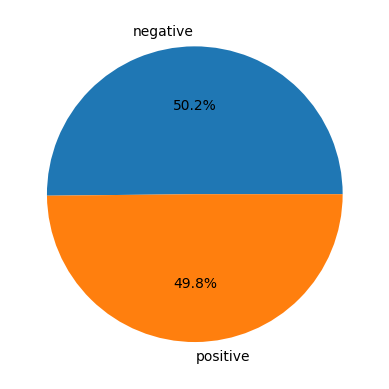

<ipython-input-5-514f6b49dd4d>:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_categories, y=label_counts.values, palette="viridis", order=sorted_categories)


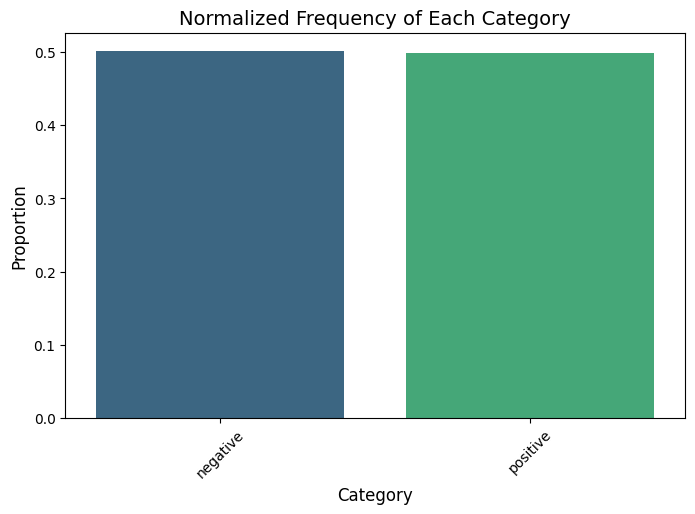



Text lengths:  [ 35  64  83  15  34   6   4  43  59   9  10  29   8  31  36  24  27  14
  50  11  37  39   1  49  57  18  53  55  42  13  16   5  19  44  22  33
  12  20   7   3  25  28 252  26  32  61 265  51 126  86  62  66  21  63
  76  23  17  38  30  71  88   2  47  48  46  52 259 256  56  58  69  79
  78  73  41 107  54  72  74  65 196  67  75 253 255  89 115  98  45  40
  91  81  77 296 103 143  96  90  70 269 180  60  99  68 110 282  92 263
 326 140  93 267  80 258  94 133  95 124  84 280 104  82 150 275  87 224
 136 179 141  97 120 308 329 225 288 195  85 105 134 112 158 102 160 276
 287 505 118 257 152 271 319 262 117 108 106 251 277 249 260 100 162 111
 131 101 240 116 506 270 164 139 254 153 274 279 171 170 315 264 458 215
 163 122 284 246 129 221 268 302 119 132 261 209 278 147 144 176 289 293
 297 142 247 191 335 121 423 128 137 123 189 248 157 285 292 169 138 130
 167 219 334 222 193 113 114 190 345 266 325 272 333 305 135 145 168 159
 109 223 298 304 146 151 211 229 3

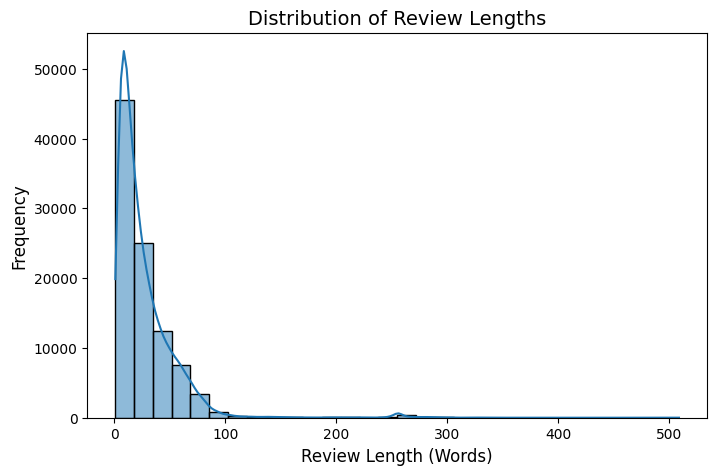

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95990 entries, 0 to 95989
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   label            95990 non-null  int64 
 1   review           95990 non-null  object
 2   translated_text  95990 non-null  object
 3   text_length      95990 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 2.9+ MB






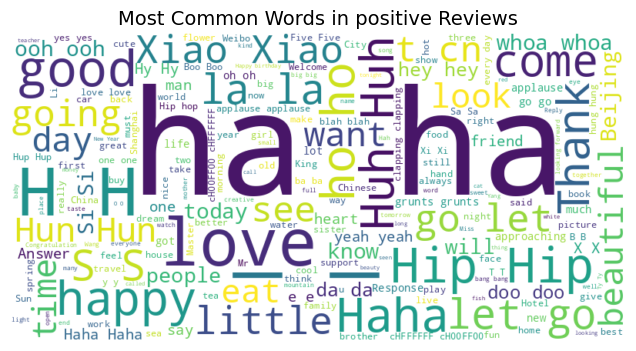

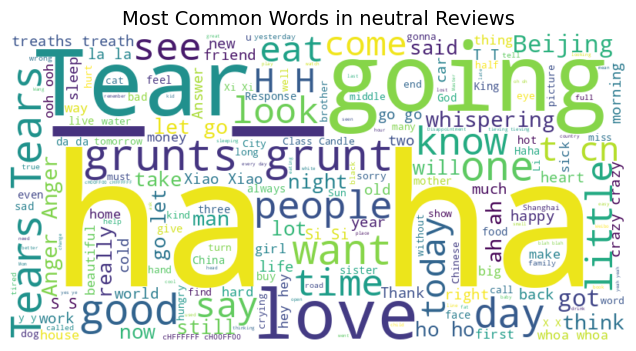

In [ ]:
custom_labels_ch = {
                0: "negative",
                1: "positive"
            }
eda = EDA(df=train_ch, labelCol="label", dataset="weibo", textCol="translated_text", custom_labels=custom_labels_ch)
eda.perform_eda()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
<ipython-input-16-5f55672e6165>:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Frequency", y="Word", data=df_word_freq, palette="coolwarm")


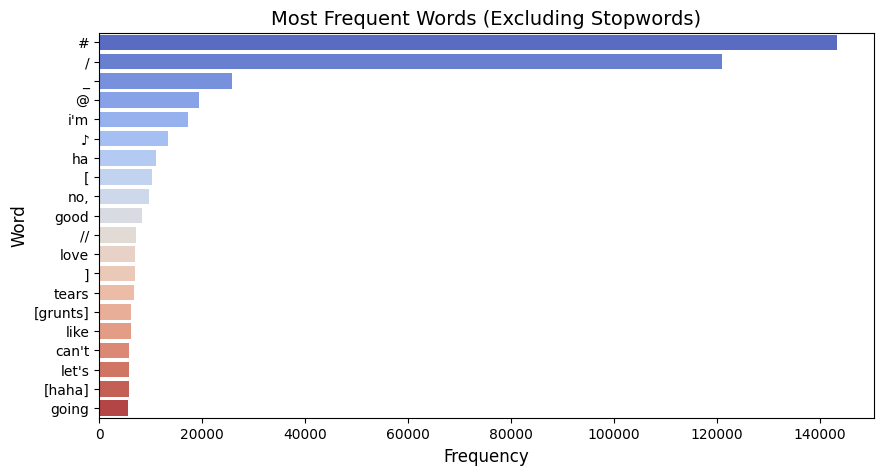

<ipython-input-16-5f55672e6165>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["filtered_text"] = df_filtered[self.textCol].apply(
<ipython-input-16-5f55672e6165>:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Frequency", y="Word", data=df_word_freq, palette="coolwarm")


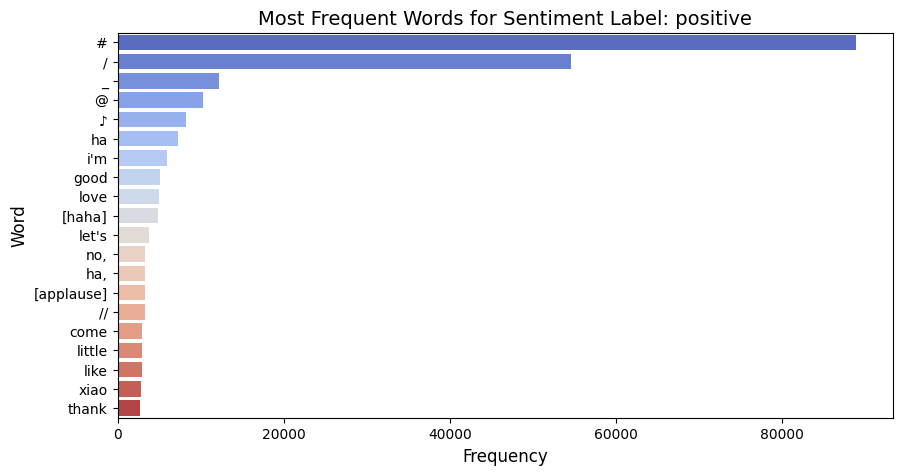

<ipython-input-16-5f55672e6165>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["filtered_text"] = df_filtered[self.textCol].apply(
<ipython-input-16-5f55672e6165>:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Frequency", y="Word", data=df_word_freq, palette="coolwarm")


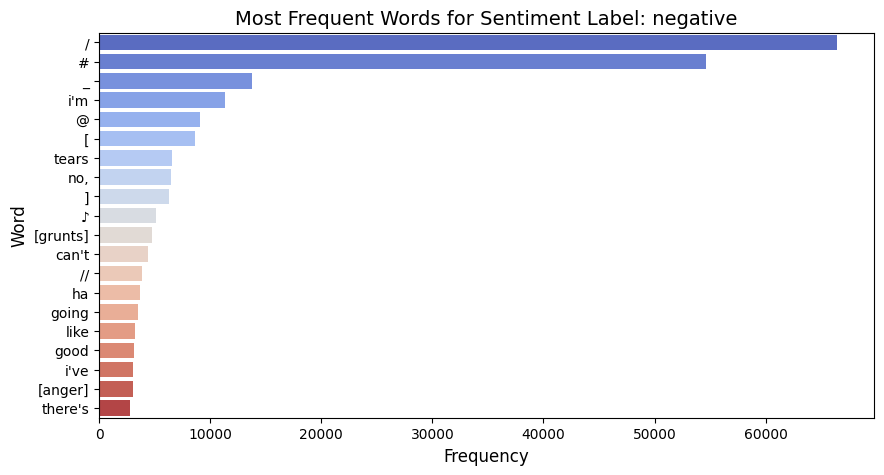




Top Positive Bigrams:
[(('ha', 'ha'), 10951), (('of', 'the'), 5784), (('love', 'you'), 4799), (('in', 'the'), 4662), (('to', 'the'), 3604), (('no', 'no'), 3314), (('let', 'go'), 2611), (('thank', 'you'), 2568), (('on', 'the'), 2421), (('i', 'love'), 2364)]

Top Negative Bigrams:
[(('no', 'no'), 6368), (('of', 'the'), 5799), (('in', 'the'), 5530), (('ha', 'ha'), 4565), (('and', 'i'), 4020), (('to', 'the'), 3327), (('on', 'the'), 2797), (('grunts', 'grunts'), 2785), (('going', 'to'), 2634), (('tears', 'tears'), 2534)]

Top Positive Trigrams:
[(('ha', 'ha', 'ha'), 10257), (('no', 'no', 'no'), 3247), (('let', 'go', 'let'), 2205), (('go', 'let', 'go'), 2196), (('xiao', 'xiao', 'xiao'), 1974), (('i', 'love', 'you'), 1661), (('whoa', 'whoa', 'whoa'), 1511), (('ooh', 'ooh', 'ooh'), 1438), (('hey', 'hey', 'hey'), 1309), (('yeah', 'yeah', 'yeah'), 1239)]

Top Negative Trigrams:
[(('no', 'no', 'no'), 6246), (('ha', 'ha', 'ha'), 4315), (('grunts', 'grunts', 'grunts'), 2159), (('tears', 'tears',

<ipython-input-16-5f55672e6165>:84: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Frequency", y="N-gram", data=ngram_df, palette="coolwarm")


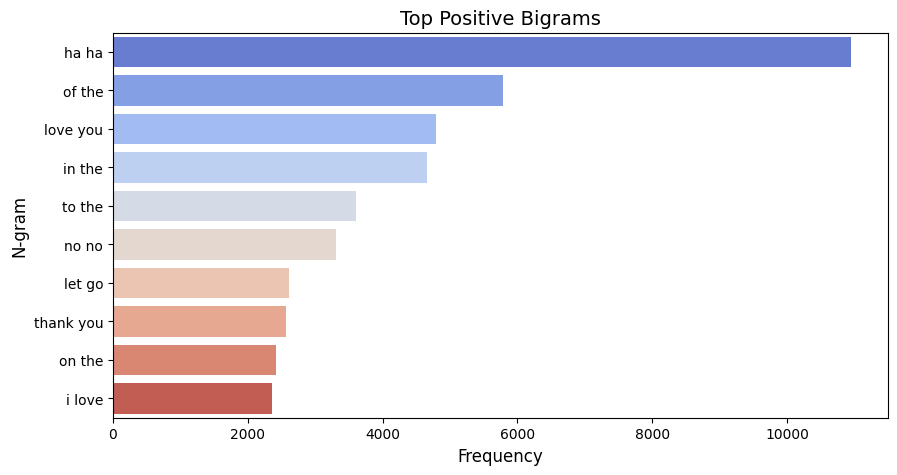

<ipython-input-16-5f55672e6165>:84: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Frequency", y="N-gram", data=ngram_df, palette="coolwarm")


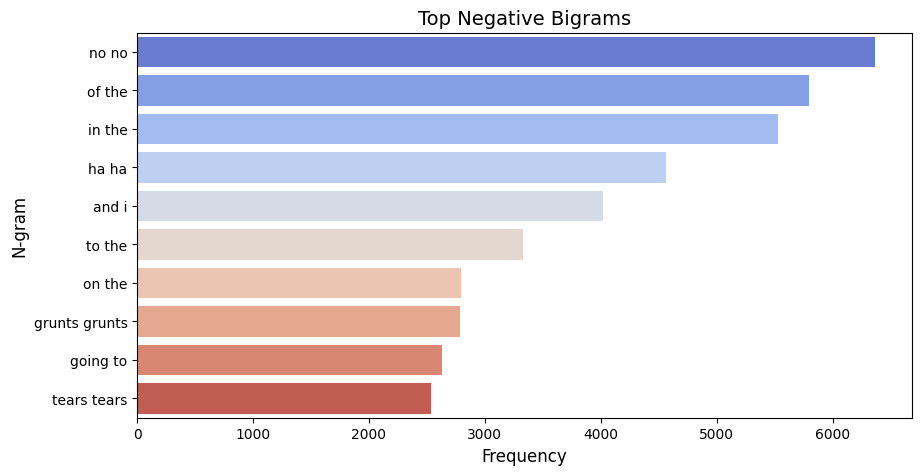

<ipython-input-16-5f55672e6165>:84: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Frequency", y="N-gram", data=ngram_df, palette="coolwarm")


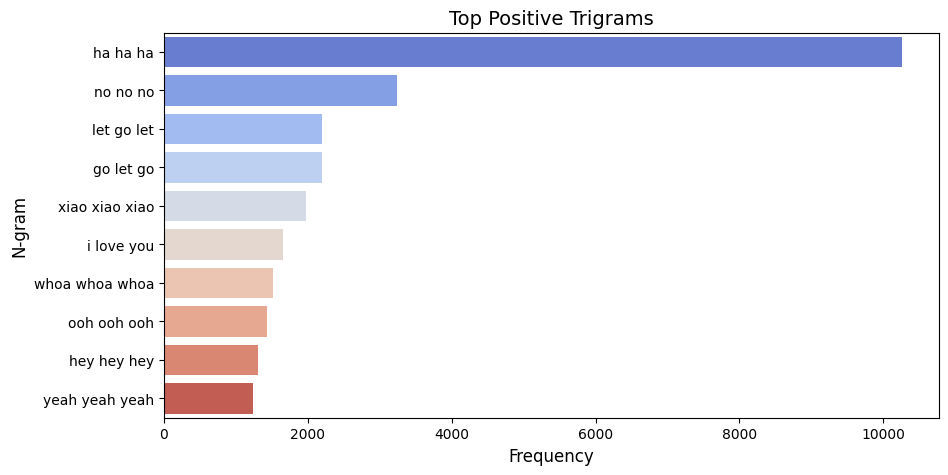

<ipython-input-16-5f55672e6165>:84: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Frequency", y="N-gram", data=ngram_df, palette="coolwarm")


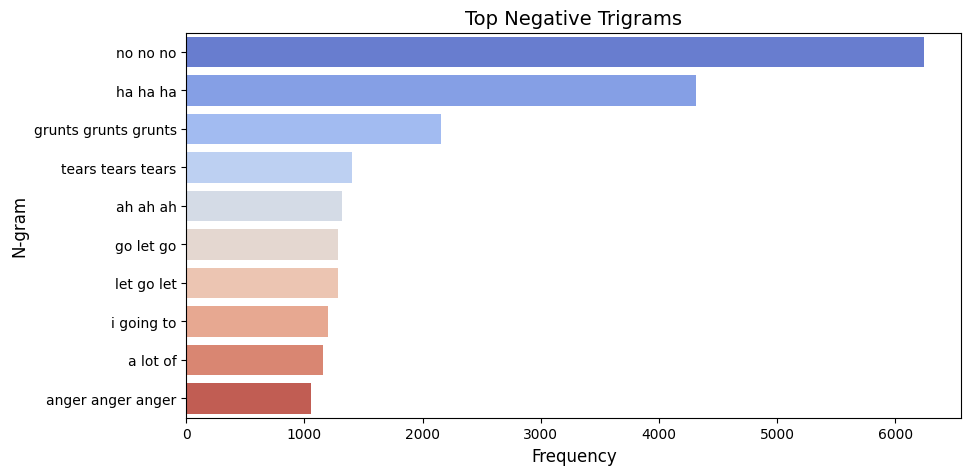

In [ ]:
eda = EDA_2(df=train_ch, labelCol="label", dataset="weibo", textCol="translated_text", custom_labels=custom_labels_ch)
eda.perform_eda()

### RuReviews Russian

In [11]:
train_ru = pd.read_csv("/content/rureviews_ru_train_translated.csv")
val_ru = pd.read_csv("/content/rureviews_val_translated.csv")
test_ru = pd.read_csv("/content/rureviews_test_translated.csv")
train_ru.head()

review sentiment  \
0  пришло быстро. по размеру подошло (90-67-94). ...  neautral   
1                         Очень долгая доставка !!!!  negative   
2  На картинке в заказе рубашка с длинными рукава...  neautral   
3                                     Деньги вернули  neautral   
4  Майка на меня увы  не села. (лямки короткие, м...  neautral   

                                     translated_text  
0  It came quickly. The size was 90-67-94, but on...  
1                           Very long delivery!!!!!!  
2  In the picture in the book, a shirt with long ...  
3                                  The money's back.  
4                          Myka hasn't landed on me.

In [26]:
sentiment_mapping_ru = {"negative": 0, "neautral": 1, "positive": 2}

# Apply mapping to sentiment column
train_ru["label"] = train_ru["sentiment"].map(sentiment_mapping_ru)
test_ru["label"] = test_ru["sentiment"].map(sentiment_mapping_ru)
val_ru["label"] = val_ru["sentiment"].map(sentiment_mapping_ru)

label
0    24058
2    24002
1    23940
Name: count, dtype: int64
label
0    0.334139
2    0.333361
1    0.332500
Name: proportion, dtype: float64
negative
positive
neautral


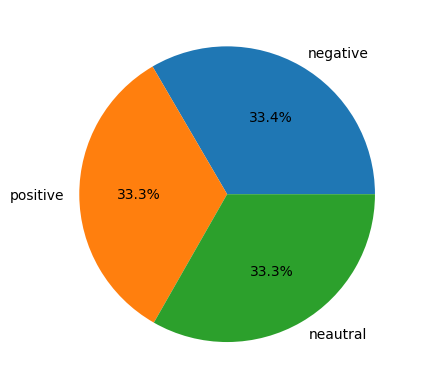

<ipython-input-20-5b45f83aec94>:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_categories, y=label_counts.values, palette="viridis", order=sorted_categories)


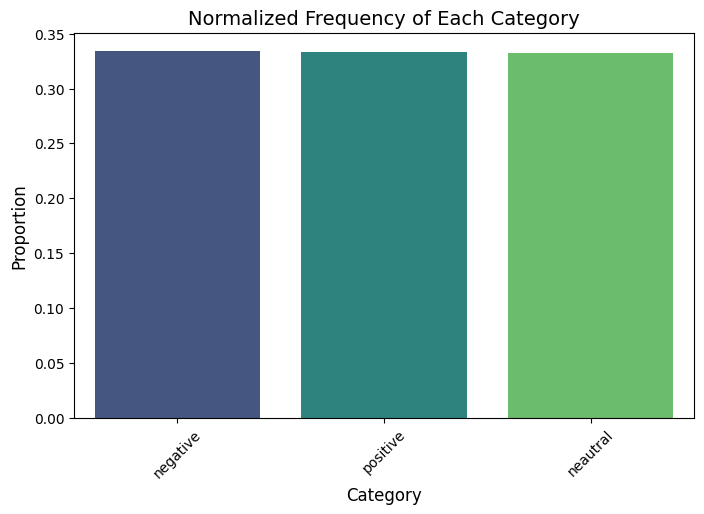



Text lengths:  [ 44   3  38   5  15  92  21  67   4  53  11  50  71  39  16   1  10  18
  27  33   6   9  24  17  29  20  14   8  13  79  90  51  19  12  22  52
  56  30  35  49  31  23  40  25  36  42  57   7  41  37  28  26  32   2
  84  54  91  85 126  34  69 204  47  43  65  60 387  72  75  46  70  62
  87 102  48  80 149 109  93  45 119 101 161 112 143  55 120 140 107  59
 224  73  61  81  64 156  66  82  98 123  76 158  96  63 180 136 114  58
  95  83 118  68  74 100  88 106 461 103 310  94 134 108 110 127  97 147
 113  89 104 125 182  99 175 117 153  78 130  86 142 186  77 116 198 105
 133 124 131 111 295 146 115 144 129 122 152 139 159 281 128 145 247 261
 121 155 132 160 297 163 164 148 181 150 138 165 509 185 135 445 362 141
 208 211 201 166 194 137 169 167 171 157 221 244 151 298 170 443 172 188
 266 179 191 356 193 439 238 195 154 259 510 364 254 162 421 248 174 183
 178 272 243 318 229 361 300 200 303 190 197 177 173 314 410 176 196 168
 258 319 232 202 213 508 302 189 4

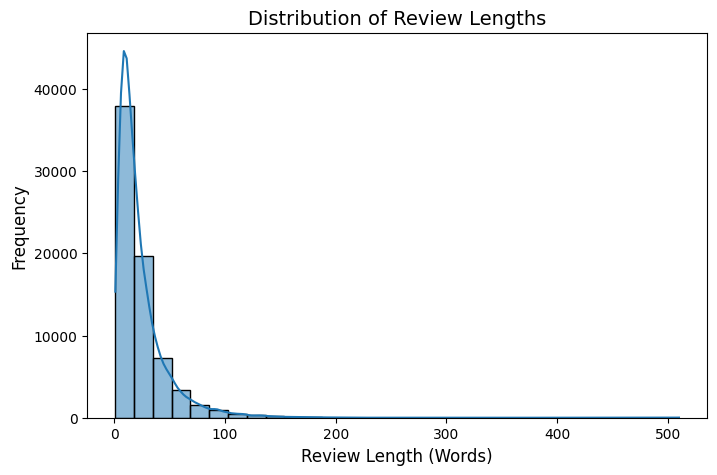

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72000 entries, 0 to 71999
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   review           72000 non-null  object
 1   sentiment        72000 non-null  object
 2   translated_text  72000 non-null  object
 3   label            72000 non-null  int64 
 4   text_length      72000 non-null  int64 
 5   filtered_text    72000 non-null  object
dtypes: int64(2), object(4)
memory usage: 3.3+ MB




In [27]:
custom_labels_ru = {
                0: "negative",
                1: "neautral",
                2: "positive",
            }
eda = EDA(df=train_ru, labelCol="label", dataset="rureviews", textCol="translated_text", custom_labels=custom_labels_ru)
eda.perform_eda()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
<ipython-input-8-11de7892ee80>:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Frequency", y="Word", data=df_word_freq, palette="coolwarm")


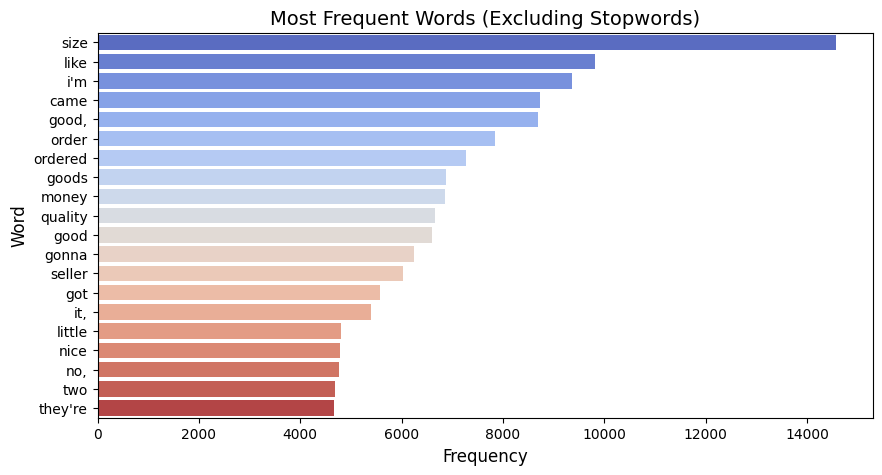

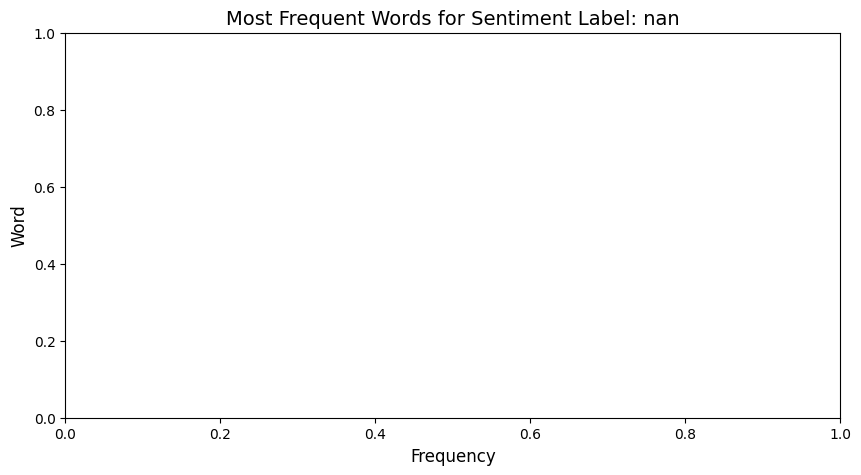

<ipython-input-8-11de7892ee80>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["filtered_text"] = df_filtered[self.textCol].apply(
<ipython-input-8-11de7892ee80>:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Frequency", y="Word", data=df_word_freq, palette="coolwarm")


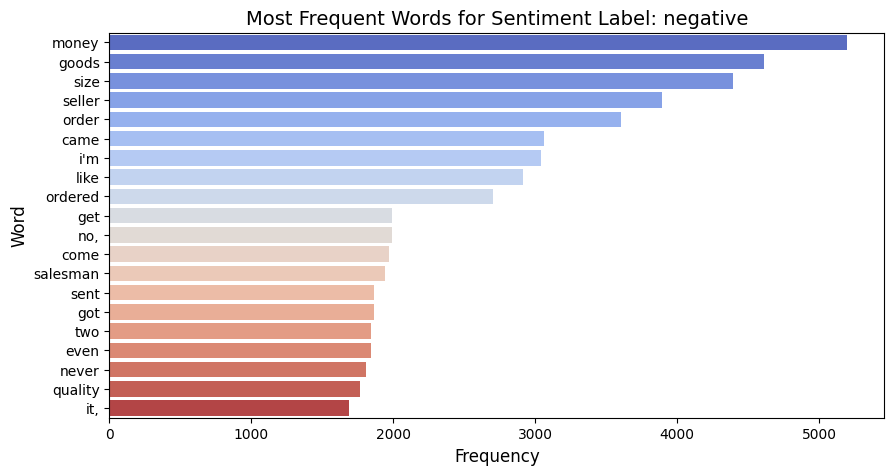

<ipython-input-8-11de7892ee80>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["filtered_text"] = df_filtered[self.textCol].apply(
<ipython-input-8-11de7892ee80>:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Frequency", y="Word", data=df_word_freq, palette="coolwarm")


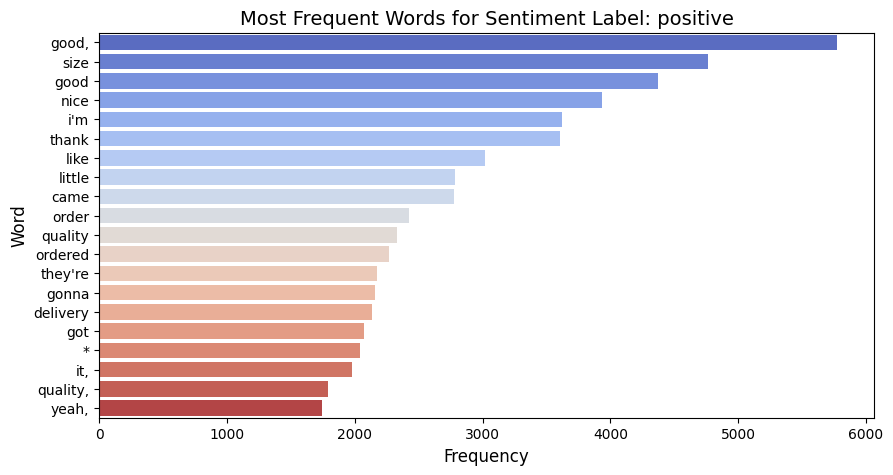




Top Positive Bigrams:
[(('to', 'the'), 4064), (('it', 'a'), 3669), (('it', 'good'), 3592), (('thank', 'you'), 3560), (('the', 'size'), 3454), (('good', 'it'), 3289), (('the', 'salesman'), 2820), (('of', 'the'), 2746), (('a', 'little'), 2675), (('in', 'the'), 2188)]

Top Negative Bigrams:
[(('the', 'money'), 6432), (('the', 'goods'), 5217), (('the', 'seller'), 4553), (('of', 'the'), 4245), (('the', 'size'), 3493), (('did', 'come'), 3412), (('and', 'the'), 3322), (('in', 'the'), 3198), (('the', 'order'), 3062), (('it', 'not'), 2523)]

Top Positive Trigrams:
[(('it', 'good', 'it'), 2815), (('good', 'it', 'good'), 2641), (('the', 'size', 'of'), 1747), (('yeah', 'yeah', 'yeah'), 1698), (('to', 'the', 'salesman'), 1557), (('thank', 'you', 'to'), 1151), (('you', 'to', 'the'), 1143), (('i', 'gon', 'na'), 1039), (('no', 'no', 'no'), 1016), (('it', 'okay', 'it'), 936)]

Top Negative Trigrams:
[(('no', 'no', 'no'), 1900), (('the', 'goods', 'did'), 1893), (('the', 'size', 'of'), 1578), (('goods

<ipython-input-8-11de7892ee80>:84: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Frequency", y="N-gram", data=ngram_df, palette="coolwarm")


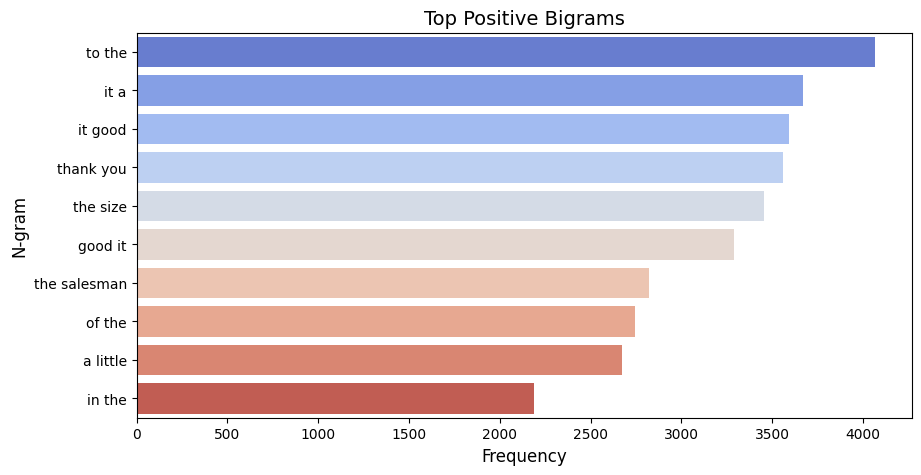

<ipython-input-8-11de7892ee80>:84: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Frequency", y="N-gram", data=ngram_df, palette="coolwarm")


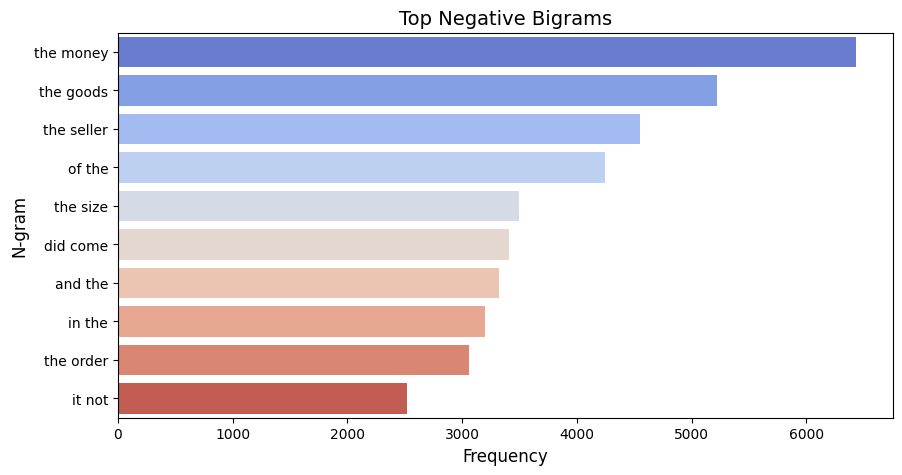

<ipython-input-8-11de7892ee80>:84: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Frequency", y="N-gram", data=ngram_df, palette="coolwarm")


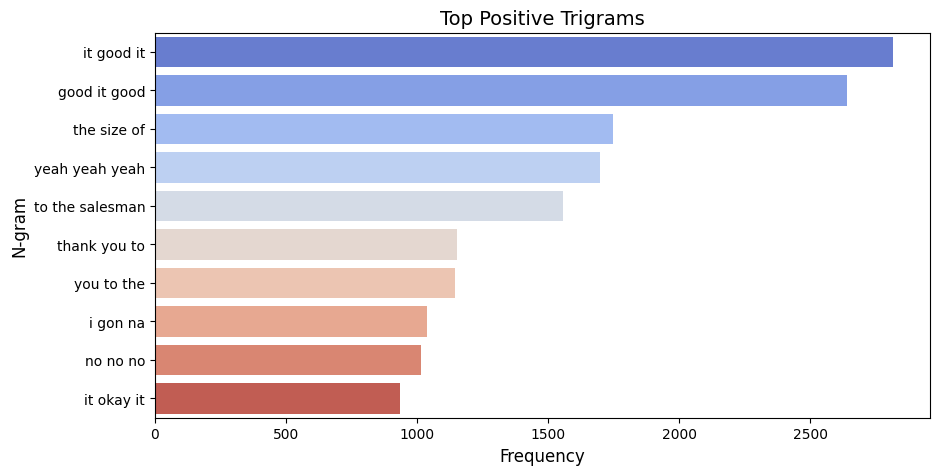

<ipython-input-8-11de7892ee80>:84: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Frequency", y="N-gram", data=ngram_df, palette="coolwarm")


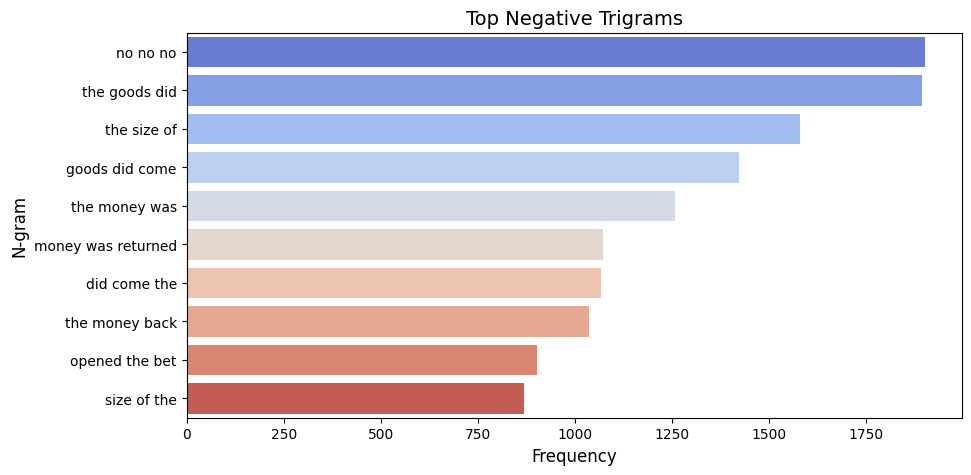

In [22]:
eda = EDA_2(df=train_ru, labelCol="label", dataset="rureviews", textCol="translated_text", custom_labels=custom_labels_ru)
eda.perform_eda()